<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 3: прогнозирование временных рядов</center></h2>

In [2]:
!pip install ruptures

In [3]:
!pip install -r requirements.txt

In [1]:
import warnings
import gdown
import pandas as pd
import numpy as np
import ruptures
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
import sklearn as sk
from etna.analysis import (cross_corr_plot, distribution_plot, plot_anomalies,
                           plot_anomalies_interactive, plot_backtest,plot_backtest_interactive,
                           plot_correlation_matrix, plot_forecast,
                           sample_acf_plot, sample_pacf_plot)
from etna.analysis.outliers import (get_anomalies_density, get_anomalies_hist,
                                    get_anomalies_median,
                                    get_anomalies_prediction_interval)
from etna.datasets import TSDataset
from etna.ensembles import DirectEnsemble, StackingEnsemble, VotingEnsemble
from etna.metrics import MAE, MAPE, MSE, SMAPE
from etna.models import (CatBoostModelPerSegment, CatBoostMultiSegmentModel,
                         LinearPerSegmentModel, MovingAverageModel, NaiveModel,
                         ProphetModel, SeasonalMovingAverageModel)
from etna.pipeline import AutoRegressivePipeline, Pipeline, assemble_pipelines
from etna.transforms import (DateFlagsTransform, FilterFeaturesTransform,
                             HolidayTransform, LagTransform,
                             LinearTrendTransform, LogTransform, MeanTransform,
                             MedianOutliersTransform, SegmentEncoderTransform,
                             TimeSeriesImputerTransform,DensityOutliersTransform)
from etna.reconciliation import BottomUpReconciliator,TopDownReconciliator

warnings.filterwarnings("ignore")

C:\Users\playi\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\playi\AppData\Local\Programs\Python\Python310\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


В данной задаче мы будем решать одну из актуальных практических задач, с которыми, в том числе, сталкиваются разработчики ETNA - прогнозирование объема необходимой наличности в банкоматах (на примере одного устройства). Пожалуй, ни для кого не секрет, что отсутствие необходимой суммы в банкомате не делает клиента банка счастливее. В то же время, избыток заправленной в банкомат наличности приводит к упущенной выгоде - ведь, в конечном счете, эти деньги могли быть размещены в качестве краткосрочного депозита на межбанковском рынке. Для кредитной организации с обширной сетью банкоматов даже незначительное улучшение качества предсказания способно внести значительный вклад в прибыльность этой ветки бизнеса. 

Мы будем использовать дневные данные реального банкомата хоть и не с российского рынка, но очень схожего с ним - турецкого. Скачаем и загрузим их:

In [2]:
url = 'https://raw.githubusercontent.com/andrei-egorov/ml_se_seminars/master/atm_daily_cash.csv'
output = 'atm_daily_cash.csv'
gdown.download(url=url, output=output, quiet=False, fuzzy=True)

df = pd.read_csv('atm_daily_cash.csv')
df = df[4:] #лучше избавиться от нескольких пропущенных значений в начале сразу,
            #могут доставлять ненужные лишние проблемы

Downloading...
From: https://raw.githubusercontent.com/andrei-egorov/ml_se_seminars/master/atm_daily_cash.csv
To: C:\Users\playi\Desktop\Важное\Git\Iad_git\sem_4_hw_3\atm_daily_cash.csv
26.1kB [00:00, 26.1MB/s]                                                                                               


Взглянем на то, что представляют из себя данные:

In [3]:
df.head()

Date   CashIn  CashOut
4  1/5/2016  20840.0  22200.0
5  1/6/2016  28460.0  18810.0
6  1/7/2016  19250.0  23210.0
7  1/8/2016  49770.0   4350.0
8  1/9/2016      NaN      NaN

В нашем распоряжении пополнения и изъятия; нас интересует нетто. Для этого будем учитывать изъятия со знаком минус, а нетто определим как сумму (такое представление пригодится нам в дальнейшем).

In [4]:
df['CashOut'] = -df['CashOut']
df['target'] = df['CashIn'] + df['CashOut']

In [5]:
df.head()

Date   CashIn  CashOut   target
4  1/5/2016  20840.0 -22200.0  -1360.0
5  1/6/2016  28460.0 -18810.0   9650.0
6  1/7/2016  19250.0 -23210.0  -3960.0
7  1/8/2016  49770.0  -4350.0  45420.0
8  1/9/2016      NaN      NaN      NaN

### Задание 1. EDA (1 балл)

Проведите разведывательный анализ данных - постройте графики, на которых можно судить о наличии тренда, сезонности и прочих зависимостей. Проанализируйте корреляции. Какие выводы вы можете сделать?

In [6]:
df.isna().sum(axis=0)

Date         0
CashIn     101
CashOut     88
target     110
dtype: int64

In [7]:
df.describe()

CashIn        CashOut        target
count    1081.000000    1094.000000   1072.000000
mean    37261.618871  -30985.648995   5976.651119
std     20583.186636   18314.048275  21551.659802
min       100.000000 -111700.000000 -75190.000000
25%     21690.000000  -40375.000000  -6277.500000
50%     34980.000000  -27895.000000   5320.000000
75%     50280.000000  -18010.000000  18515.000000
max    121300.000000      -0.000000  85160.000000

<Axes: >

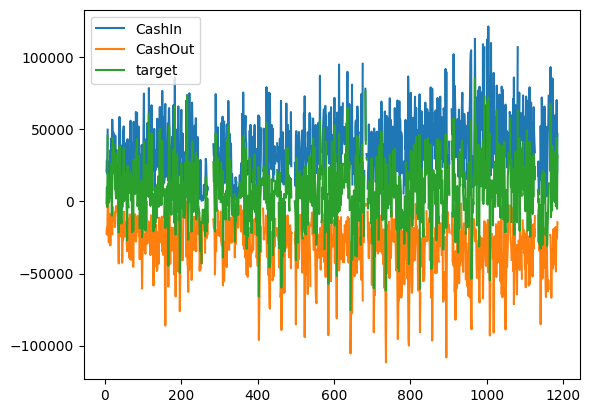

In [8]:
df.plot()

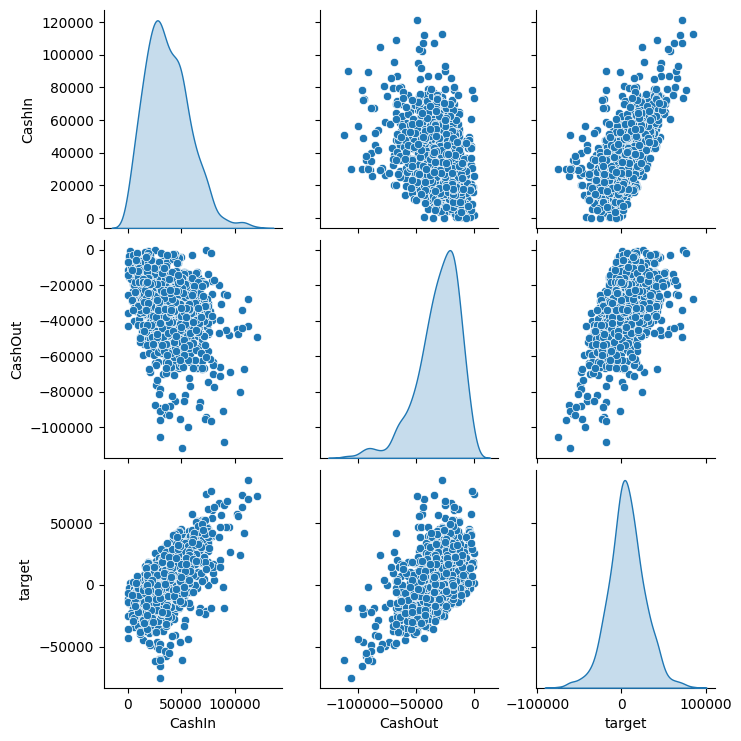

In [9]:
sns.pairplot(df, diag_kind="kde");

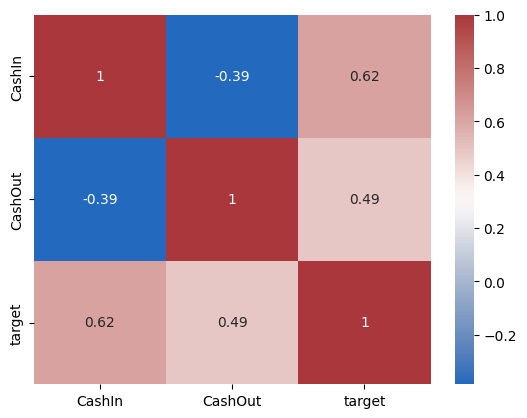

In [10]:
cmap = sns.color_palette("vlag", as_cmap=True)
sns.heatmap(df.corr("pearson"), annot=True, cmap=cmap);

In [11]:
df_copy = deepcopy(df)

In [12]:
df_copy.rename(columns = {'Date':'timestamp'}, inplace = True )

In [13]:
df_copy.head()

timestamp   CashIn  CashOut   target
4  1/5/2016  20840.0 -22200.0  -1360.0
5  1/6/2016  28460.0 -18810.0   9650.0
6  1/7/2016  19250.0 -23210.0  -3960.0
7  1/8/2016  49770.0  -4350.0  45420.0
8  1/9/2016      NaN      NaN      NaN

In [14]:
df_copy.describe()

CashIn        CashOut        target
count    1081.000000    1094.000000   1072.000000
mean    37261.618871  -30985.648995   5976.651119
std     20583.186636   18314.048275  21551.659802
min       100.000000 -111700.000000 -75190.000000
25%     21690.000000  -40375.000000  -6277.500000
50%     34980.000000  -27895.000000   5320.000000
75%     50280.000000  -18010.000000  18515.000000
max    121300.000000      -0.000000  85160.000000

In [15]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1182 entries, 4 to 1185
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  1182 non-null   object 
 1   CashIn     1081 non-null   float64
 2   CashOut    1094 non-null   float64
 3   target     1072 non-null   float64
dtypes: float64(3), object(1)
memory usage: 37.1+ KB


<Axes: xlabel='timestamp'>

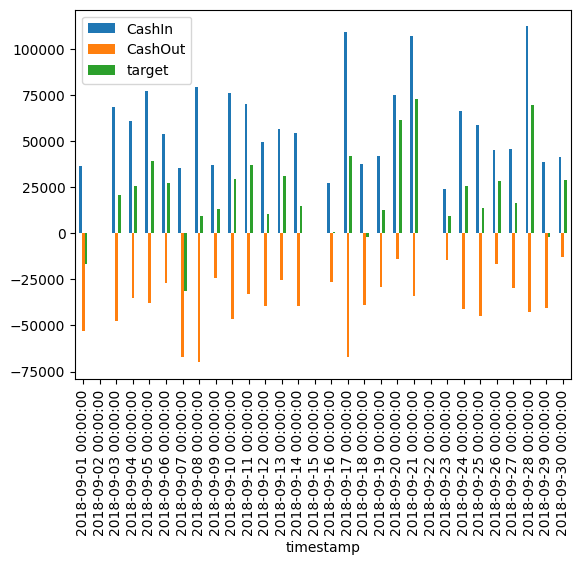

In [16]:
df_copy["timestamp"] = df_copy["timestamp"].astype("datetime64")
df_copy.loc[(df_copy["timestamp"].dt.year == 2018) & (df_copy["timestamp"].dt.month ==9)].plot(kind="bar",x ="timestamp")

In [17]:
df_copy

timestamp   CashIn  CashOut   target
4    2016-01-05  20840.0 -22200.0  -1360.0
5    2016-01-06  28460.0 -18810.0   9650.0
6    2016-01-07  19250.0 -23210.0  -3960.0
7    2016-01-08  49770.0  -4350.0  45420.0
8    2016-01-09      NaN      NaN      NaN
...         ...      ...      ...      ...
1181 2019-03-27  45160.0 -48600.0  -3440.0
1182 2019-03-28  39480.0 -22840.0  16640.0
1183 2019-03-29  70260.0 -25950.0  44310.0
1184 2019-03-30  19250.0 -24350.0  -5100.0
1185 2019-03-31  46870.0 -14400.0  32470.0

[1182 rows x 4 columns]

In [18]:
month = 4

### Задание 2. Приведение в формат multi-segment (0.75 балла)

Теперь нам предстоит (в первый раз) привести данные к формату, в котором с ними будет возможно работать средствами ETNA. Вначале мы будем рассматривать и предсказывать наши данные как мульти-сегментные. Чтобы привести данные в соответствующий формат, вам пригодится функция `pd.melt`. На выходе у нас должен получиться объект `TSDataset`. Поскольку мы будем смотреть на данные не только в этом разрезе, лучше не менять исходный датафрейм и работать с копией.

In [21]:
from etna.datasets import TSDataset

In [22]:
df_melt = pd.melt(df_copy, id_vars=['timestamp'], value_vars=['CashIn','CashOut','target'],var_name='segment', value_name='target')

In [23]:
df_melt

timestamp segment   target
0    2016-01-05  CashIn  20840.0
1    2016-01-06  CashIn  28460.0
2    2016-01-07  CashIn  19250.0
3    2016-01-08  CashIn  49770.0
4    2016-01-09  CashIn      NaN
...         ...     ...      ...
3541 2019-03-27  target  -3440.0
3542 2019-03-28  target  16640.0
3543 2019-03-29  target  44310.0
3544 2019-03-30  target  -5100.0
3545 2019-03-31  target  32470.0

[3546 rows x 3 columns]

In [24]:
df_melt['segment']

0       CashIn
1       CashIn
2       CashIn
3       CashIn
4       CashIn
         ...  
3541    target
3542    target
3543    target
3544    target
3545    target
Name: segment, Length: 3546, dtype: object

In [25]:
df_melt = TSDataset.to_dataset(df_melt)
ts = TSDataset(df_melt, freq="D")
# ts = ts.dropna()
ts.info()

<class 'etna.datasets.TSDataset'>
num_segments: 3
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: D
         start_timestamp end_timestamp  length  num_missing
segments                                                   
CashIn        2016-01-05    2019-03-31    1182          101
CashOut       2016-01-05    2019-03-31    1182           88
target        2016-01-05    2019-03-31    1182          110


In [26]:
ts.head()

segment      CashIn  CashOut   target
feature      target   target   target
timestamp                            
2016-01-05  20840.0 -22200.0  -1360.0
2016-01-06  28460.0 -18810.0   9650.0
2016-01-07  19250.0 -23210.0  -3960.0
2016-01-08  49770.0  -4350.0  45420.0
2016-01-09      NaN      NaN      NaN

In [27]:
ts.describe()

start_timestamp end_timestamp  length  num_missing  num_segments  \
segments                                                                    
CashIn        2016-01-05    2019-03-31    1182          101             3   
CashOut       2016-01-05    2019-03-31    1182           88             3   
target        2016-01-05    2019-03-31    1182          110             3   

          num_exogs  num_regressors  num_known_future freq  
segments                                                    
CashIn            0               0                 0    D  
CashOut           0               0                 0    D  
target            0               0                 0    D

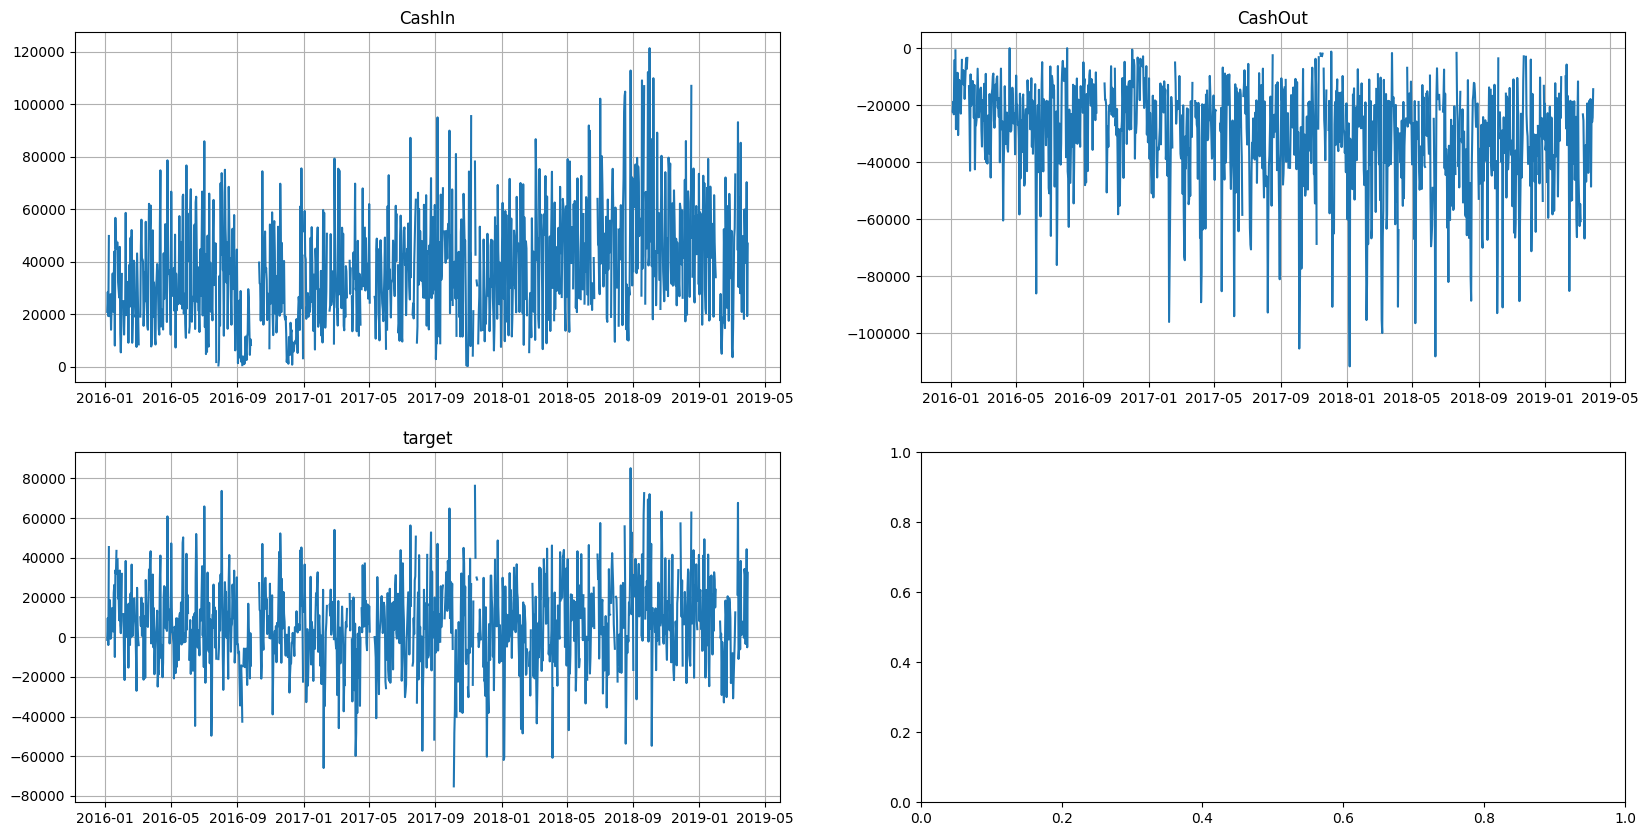

In [28]:
ts.plot()

### Задание 3. Работа с пропущенными значениями и аутлаерами (1 балл)

Проанализируйте, есть ли в данных пропущенные значения, и подберите оптимальный метод их заполнения средствами ETNA. Какие методы вы выберете и почему? Совет: возможно, лучше сохранить заполненные данные в отдельный объект, поскольку некоторые модели заполняют пропуски встроенными методами, и подача на вход "сырых" данных (на языке временных рядов это данные с нерегулярными интервалами) может принести лучший результат.

Импорты всех необходимых компонент произведите самостоятельно.

Проверьте ряды на наличие аутлаеров, и очистите их соответствующим образом. Обоснуйте выбор.

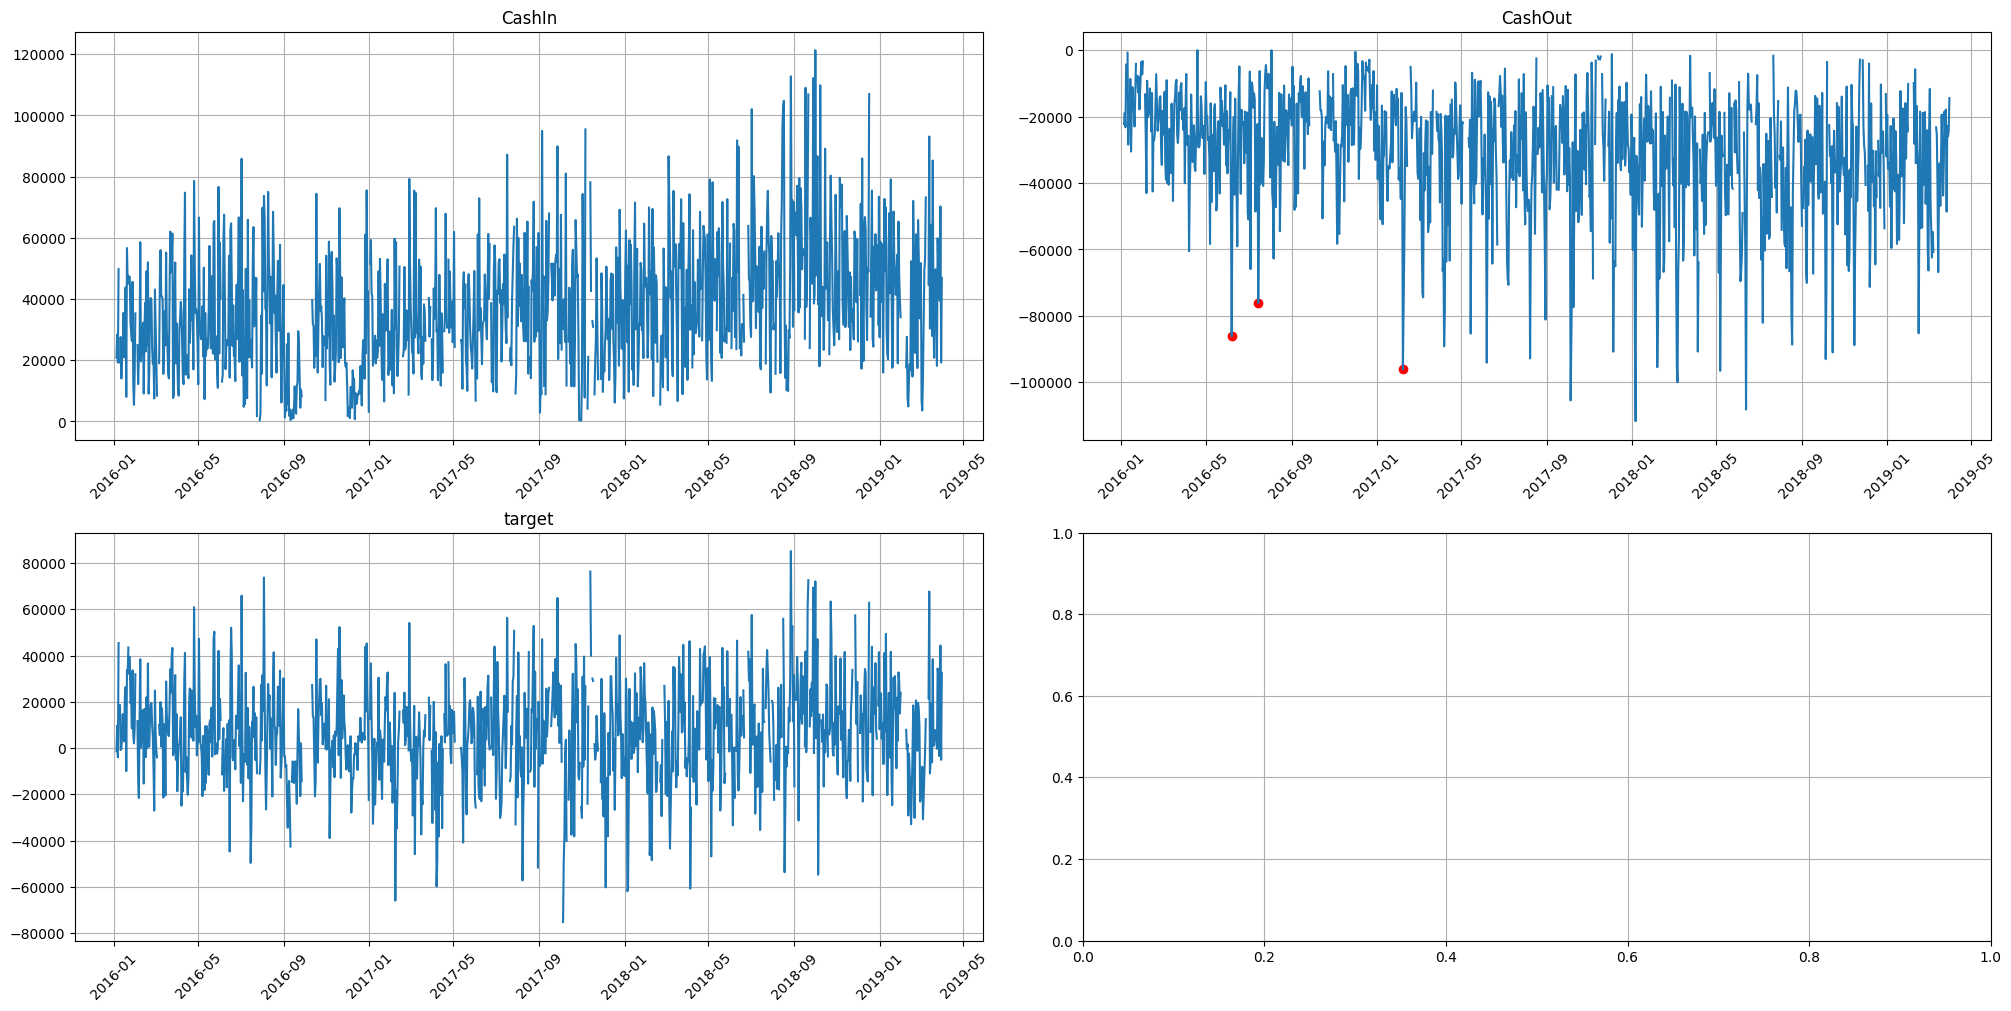

In [29]:
anomaly_dict = get_anomalies_median(ts, window_size=100) #задаем размер окна
plot_anomalies(ts, anomaly_dict)

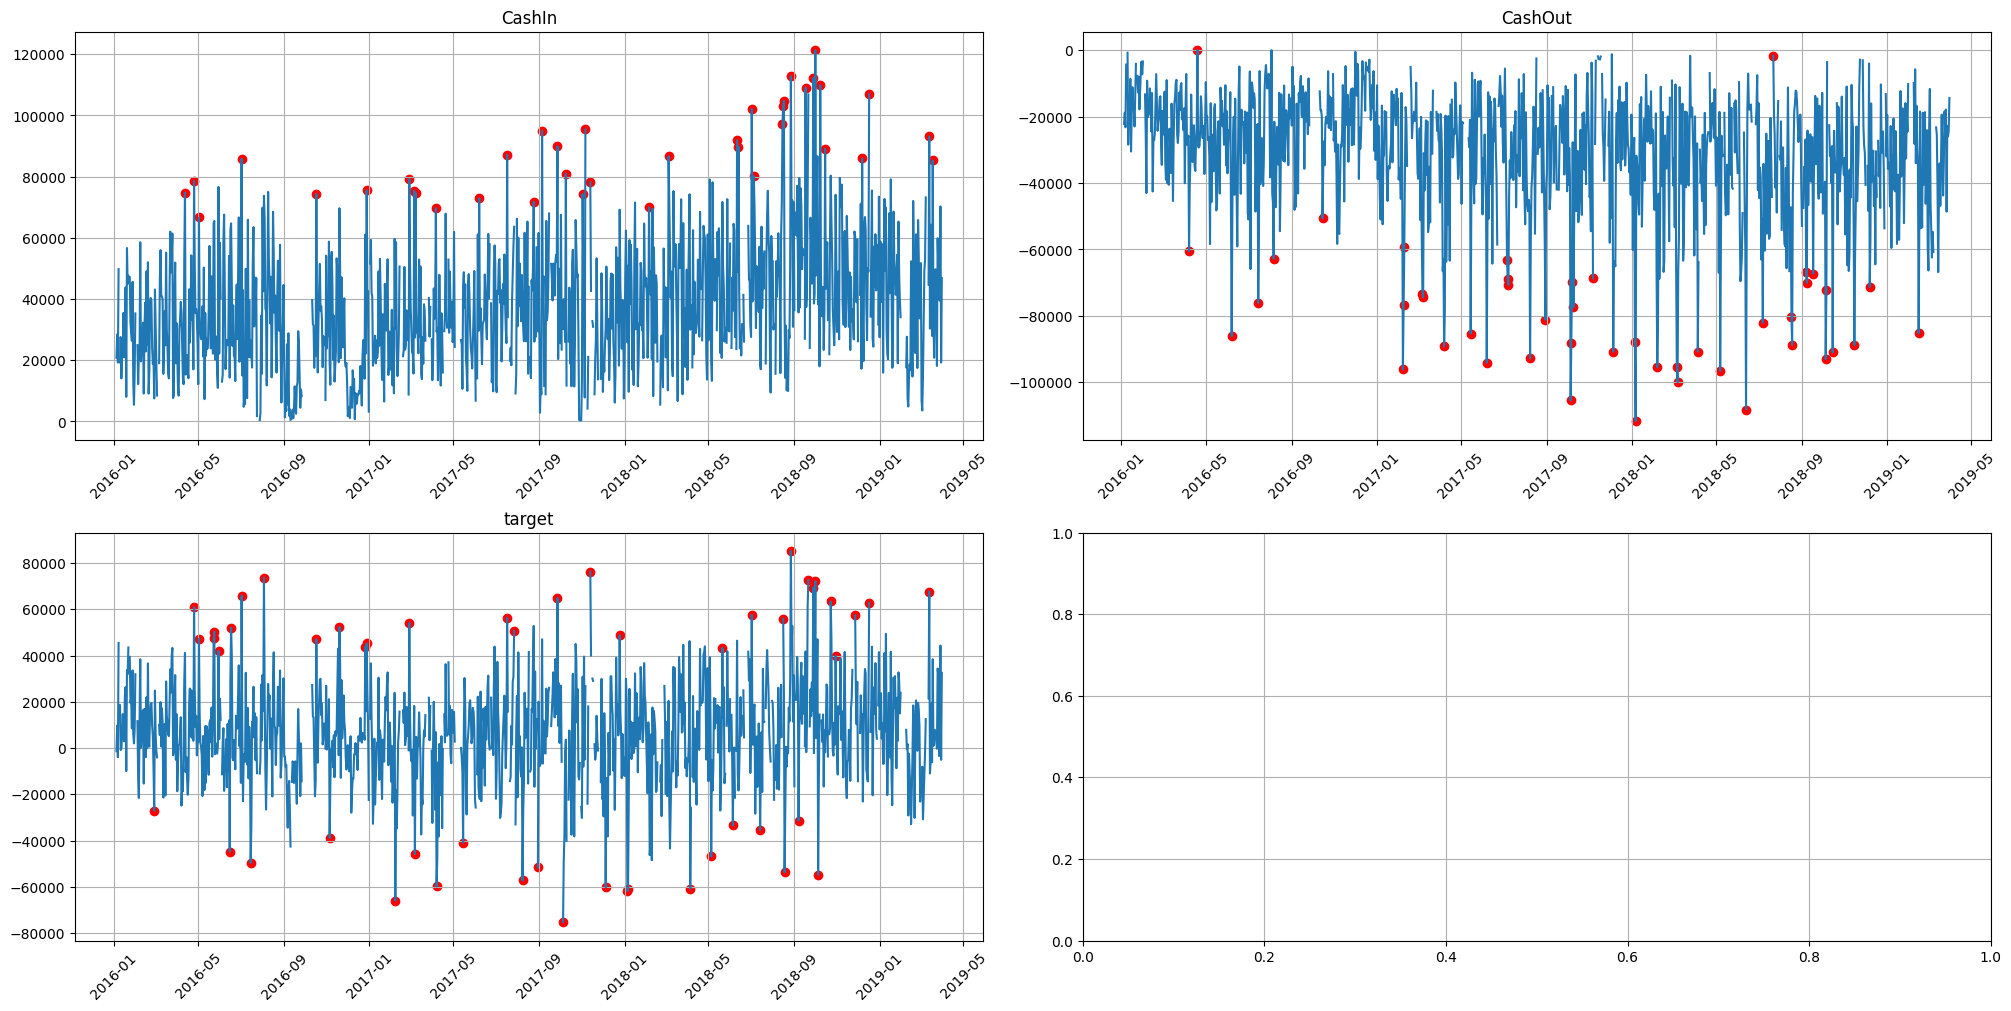

In [515]:
anomaly_dict = get_anomalies_density(ts, window_size=18, distance_coef=1, n_neighbors=4)
plot_anomalies(ts, anomaly_dict)

18:42:34 - cmdstanpy - INFO - Chain [1] start processing
18:42:34 - cmdstanpy - INFO - Chain [1] done processing
18:42:34 - cmdstanpy - INFO - Chain [1] start processing
18:42:34 - cmdstanpy - INFO - Chain [1] done processing
18:42:34 - cmdstanpy - INFO - Chain [1] start processing
18:42:34 - cmdstanpy - INFO - Chain [1] done processing


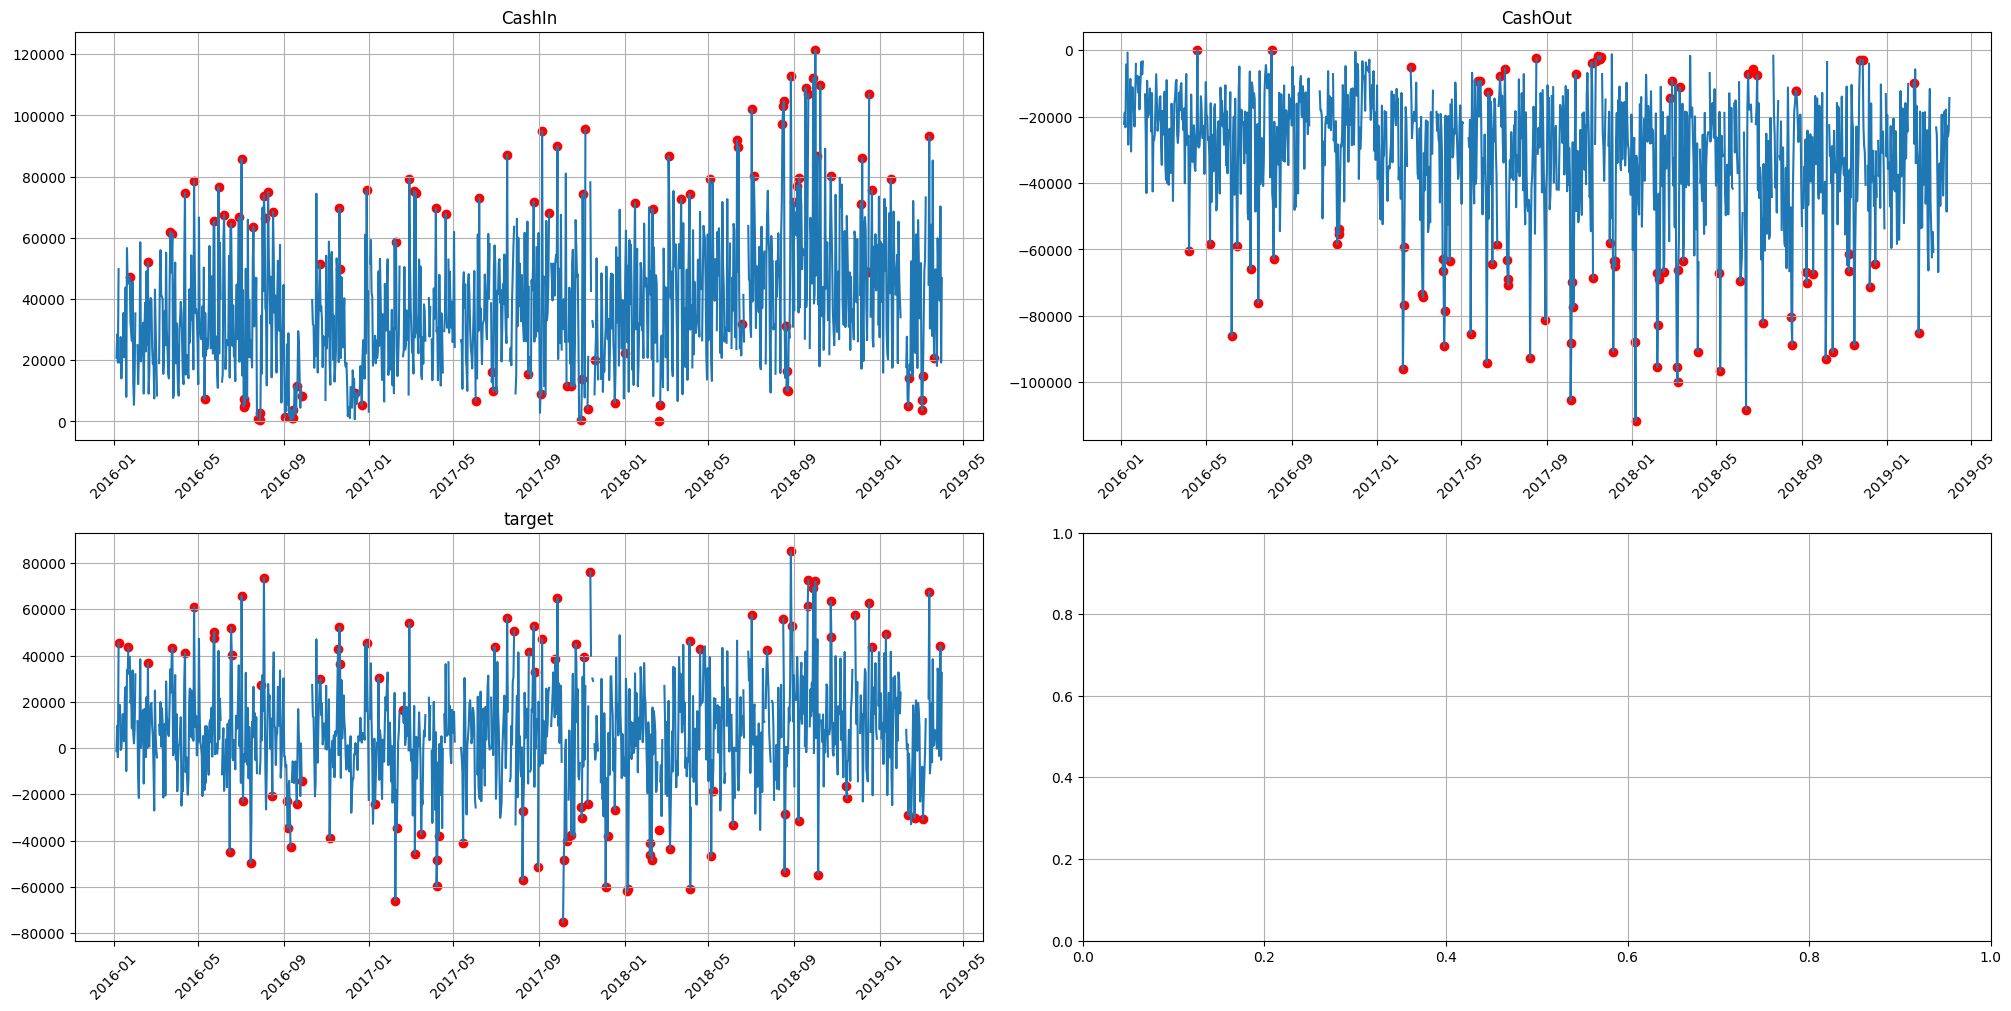

In [516]:
anomaly_dict = get_anomalies_prediction_interval(
    ts, model=ProphetModel, interval_width=0.9
)

plot_anomalies(ts, anomaly_dict)

In [1040]:
segment = "CashOut"
method = get_anomalies_density
params_bounds = {"window_size": (10, 100, 1), "distance_coef": (0.1, 4, 0.1),"n_neighbors":(1, 30, 1)}


In [1041]:
plot_anomalies_interactive(
    ts=ts, segment=segment, method=method, params_bounds=params_bounds
)

interactive(children=(IntSlider(value=10, continuous_update=False, description='window_size', min=10, style=Sl…

In [1042]:
plot_anomalies_interactive(
    ts=ts, segment='CashIn', method=method, params_bounds=params_bounds
)

interactive(children=(IntSlider(value=10, continuous_update=False, description='window_size', min=10, style=Sl…

In [35]:
best_params = {"window_size": 32, "distance_coef": 1.2,"n_neighbors":14}

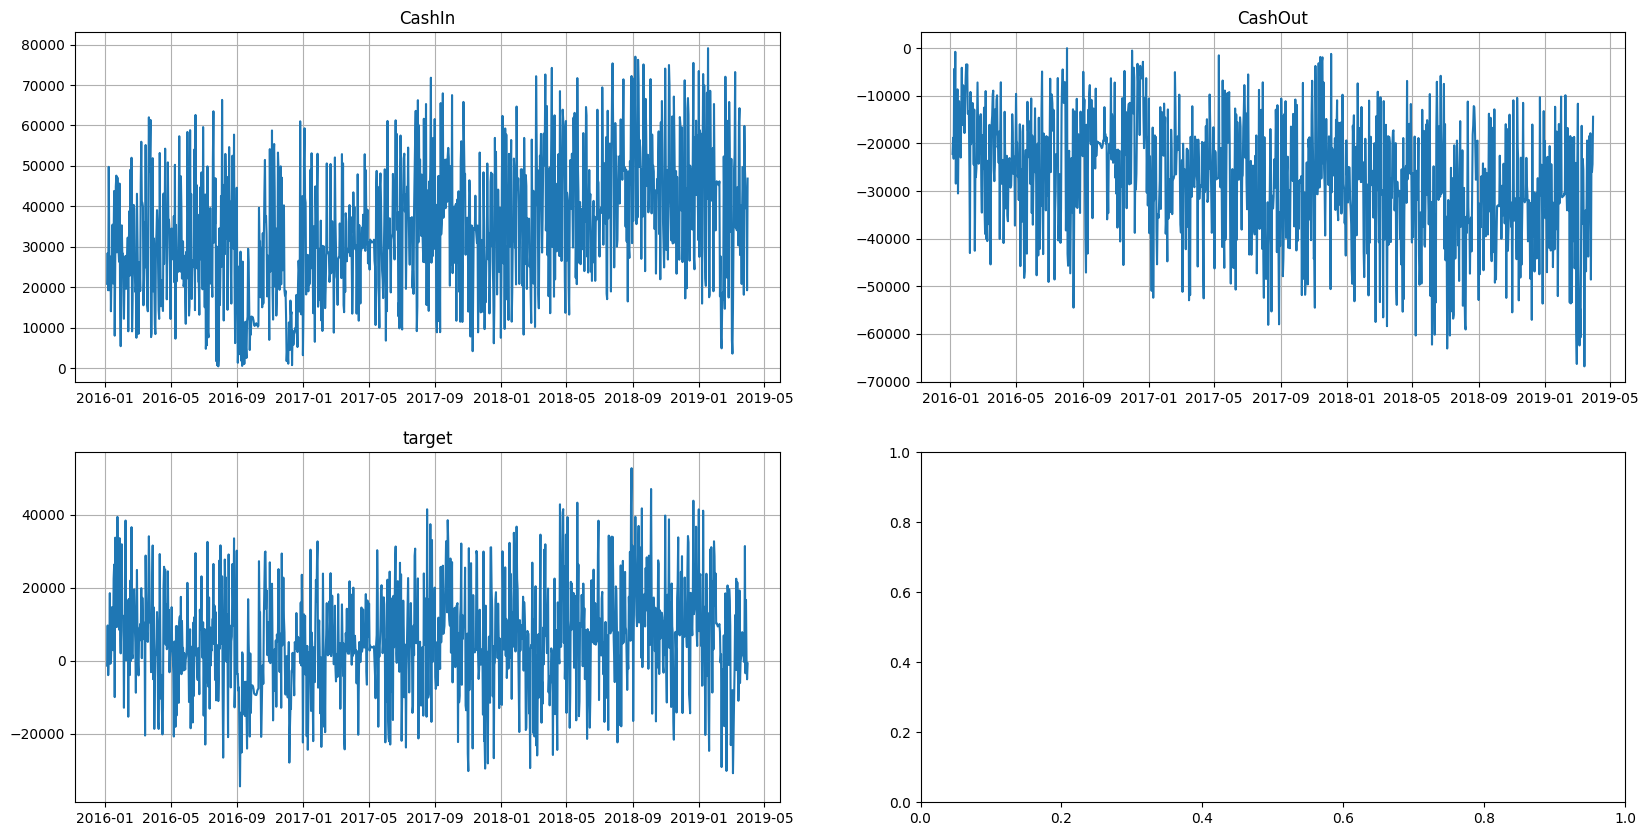

In [36]:
best_params = {"window_size": 32, "distance_coef": 1.2,"n_neighbors":14}
outliers_remover = DensityOutliersTransform(in_column="target", **best_params)
# Impute NaNs using the specified strategy
outliers_imputer = TimeSeriesImputerTransform(
    in_column="target", strategy="running_mean", window=31
)
ts.fit_transform([outliers_remover, outliers_imputer])
ts.plot()

### Задание 4. Построение мультисегментной модели (1.25 балла)

Постройте мульти-сегментную модель на основе Prophet, и оцените качество по SMAPE на кросс-валидации. В качестве горизонта предсказания возьмите 5 дней - этого же горизонта будем придерживаться и в дальнейшем.

Отрисуйте получившийся прогноз.

In [37]:
from etna.pipeline import Pipeline
from etna.models import ProphetModel
from etna.metrics import SMAPE, MAE
from etna.analysis import plot_backtest

In [38]:
HORIZON = 5 #горизонт предсказание

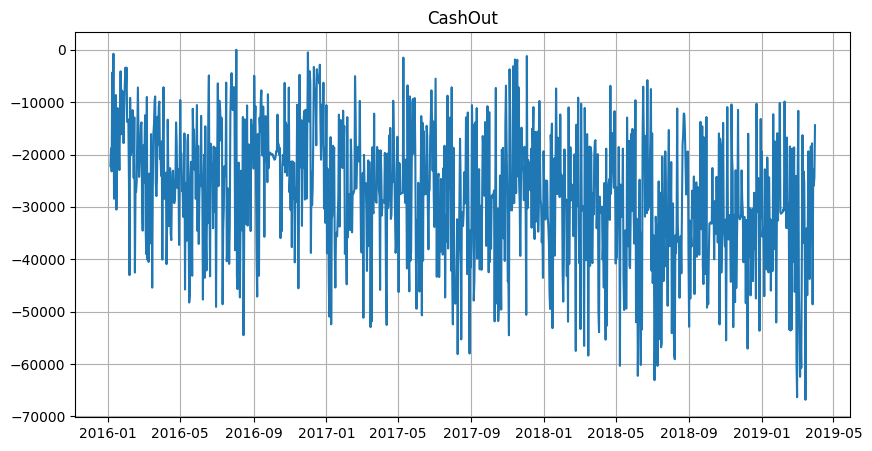

In [39]:
ts.plot(segments=["CashOut"])

In [40]:
model = ProphetModel()  # будем использовать Prophet
transforms = []  # пока оставим пустым
pipeline = Pipeline(model=model, transforms=transforms, horizon=HORIZON) 

In [41]:
metrics_df, forecast_df, fold_info_df = pipeline.backtest(
    ts=ts, metrics=[MAE(), SMAPE()]
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
23:33:50 - cmdstanpy - INFO - Chain [1] start processing
23:33:50 - cmdstanpy - INFO - Chain [1] done processing
23:33:50 - cmdstanpy - INFO - Chain [1] start processing
23:33:50 - cmdstanpy - INFO - Chain [1] done processing
23:33:50 - cmdstanpy - INFO - Chain [1] start processing
23:33:50 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s
23:33:53 - cmdstanpy - INFO - Chain [1] start processing
23:33:53 - cmdstanpy - INFO - Chain [1] done processing
23:33:53 - cmdstanpy - INFO - Chain [1] start processing
23:33:54 - cmdstanpy - INFO - Chain [1] done processing
23:33:54 - cmdstanpy - INFO - Chain [1] start processing
23:33:54 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.7s remaining:    0.0s
23:33:57 - cmdstanpy - INFO - Chain [1] start processing
23:33:57 - cmdstanpy - I

In [42]:
metrics_df.head(100)

segment           MAE       SMAPE  fold_number
0   CashIn  12356.124306   25.185711            0
0   CashIn  15588.109136   32.804808            1
0   CashIn  19760.207673   47.182404            2
0   CashIn   6394.097683   19.023575            3
0   CashIn  13175.553236   34.183608            4
2  CashOut  11470.259664   30.373638            0
2  CashOut  12877.474050   32.567092            1
2  CashOut   8068.758235   24.958728            2
2  CashOut  10691.664828   36.096552            3
2  CashOut  12886.039000   43.445572            4
1   target  10407.697186  158.253059            0
1   target  15239.397549  160.719285            1
1   target   9672.951979  149.896211            2
1   target   8529.315729  116.712759            3
1   target   7852.197852  169.985076            4

In [43]:

metrics_df_agg, forecast_df_agg, fold_info_df_agg = pipeline.backtest(
    ts=ts, metrics=[MAE(), SMAPE()], aggregate_metrics=True
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
23:34:08 - cmdstanpy - INFO - Chain [1] start processing
23:34:08 - cmdstanpy - INFO - Chain [1] done processing
23:34:08 - cmdstanpy - INFO - Chain [1] start processing
23:34:08 - cmdstanpy - INFO - Chain [1] done processing
23:34:08 - cmdstanpy - INFO - Chain [1] start processing
23:34:08 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s
23:34:11 - cmdstanpy - INFO - Chain [1] start processing
23:34:11 - cmdstanpy - INFO - Chain [1] done processing
23:34:11 - cmdstanpy - INFO - Chain [1] start processing
23:34:11 - cmdstanpy - INFO - Chain [1] done processing
23:34:12 - cmdstanpy - INFO - Chain [1] start processing
23:34:12 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.1s remaining:    0.0s
23:34:15 - cmdstanpy - INFO - Chain [1] start processing
23:34:15 - cmdstanpy - I

In [44]:
metrics_df_agg.head()

segment           MAE       SMAPE
0   CashIn  13454.818407   31.676021
1  CashOut  11198.839155   33.488316
2   target  10340.312059  151.113278

In [45]:
forecast_df.head()

segment         CashIn                   CashOut                    target  \
feature    fold_number        target fold_number        target fold_number   
timestamp                                                                    
2019-03-07           0  49515.189762           0 -38125.398426           0   
2019-03-08           0  48517.783616           0 -41229.670201           0   
2019-03-09           0  43349.030271           0 -40700.453846           0   
2019-03-10           0  36042.872091           0 -28910.066559           0   
2019-03-11           0  56538.383773           0 -41999.134923           0   

segment                   
feature           target  
timestamp                 
2019-03-07   7994.483280  
2019-03-08   5939.096417  
2019-03-09   2166.740861  
2019-03-10   5599.896585  
2019-03-11  11520.497655

In [46]:
new_forecast_df = deepcopy(forecast_df_agg)
new_forecast_df['target','target'] = new_forecast_df['CashOut','target'] +new_forecast_df['CashIn','target']
new_forecast_df.head()

segment         CashIn                   CashOut                    target  \
feature    fold_number        target fold_number        target fold_number   
timestamp                                                                    
2019-03-07           0  49515.189762           0 -38125.398426           0   
2019-03-08           0  48517.783616           0 -41229.670201           0   
2019-03-09           0  43349.030271           0 -40700.453846           0   
2019-03-10           0  36042.872091           0 -28910.066559           0   
2019-03-11           0  56538.383773           0 -41999.134923           0   

segment                   
feature           target  
timestamp                 
2019-03-07  11389.791336  
2019-03-08   7288.113415  
2019-03-09   2648.576425  
2019-03-10   7132.805532  
2019-03-11  14539.248849

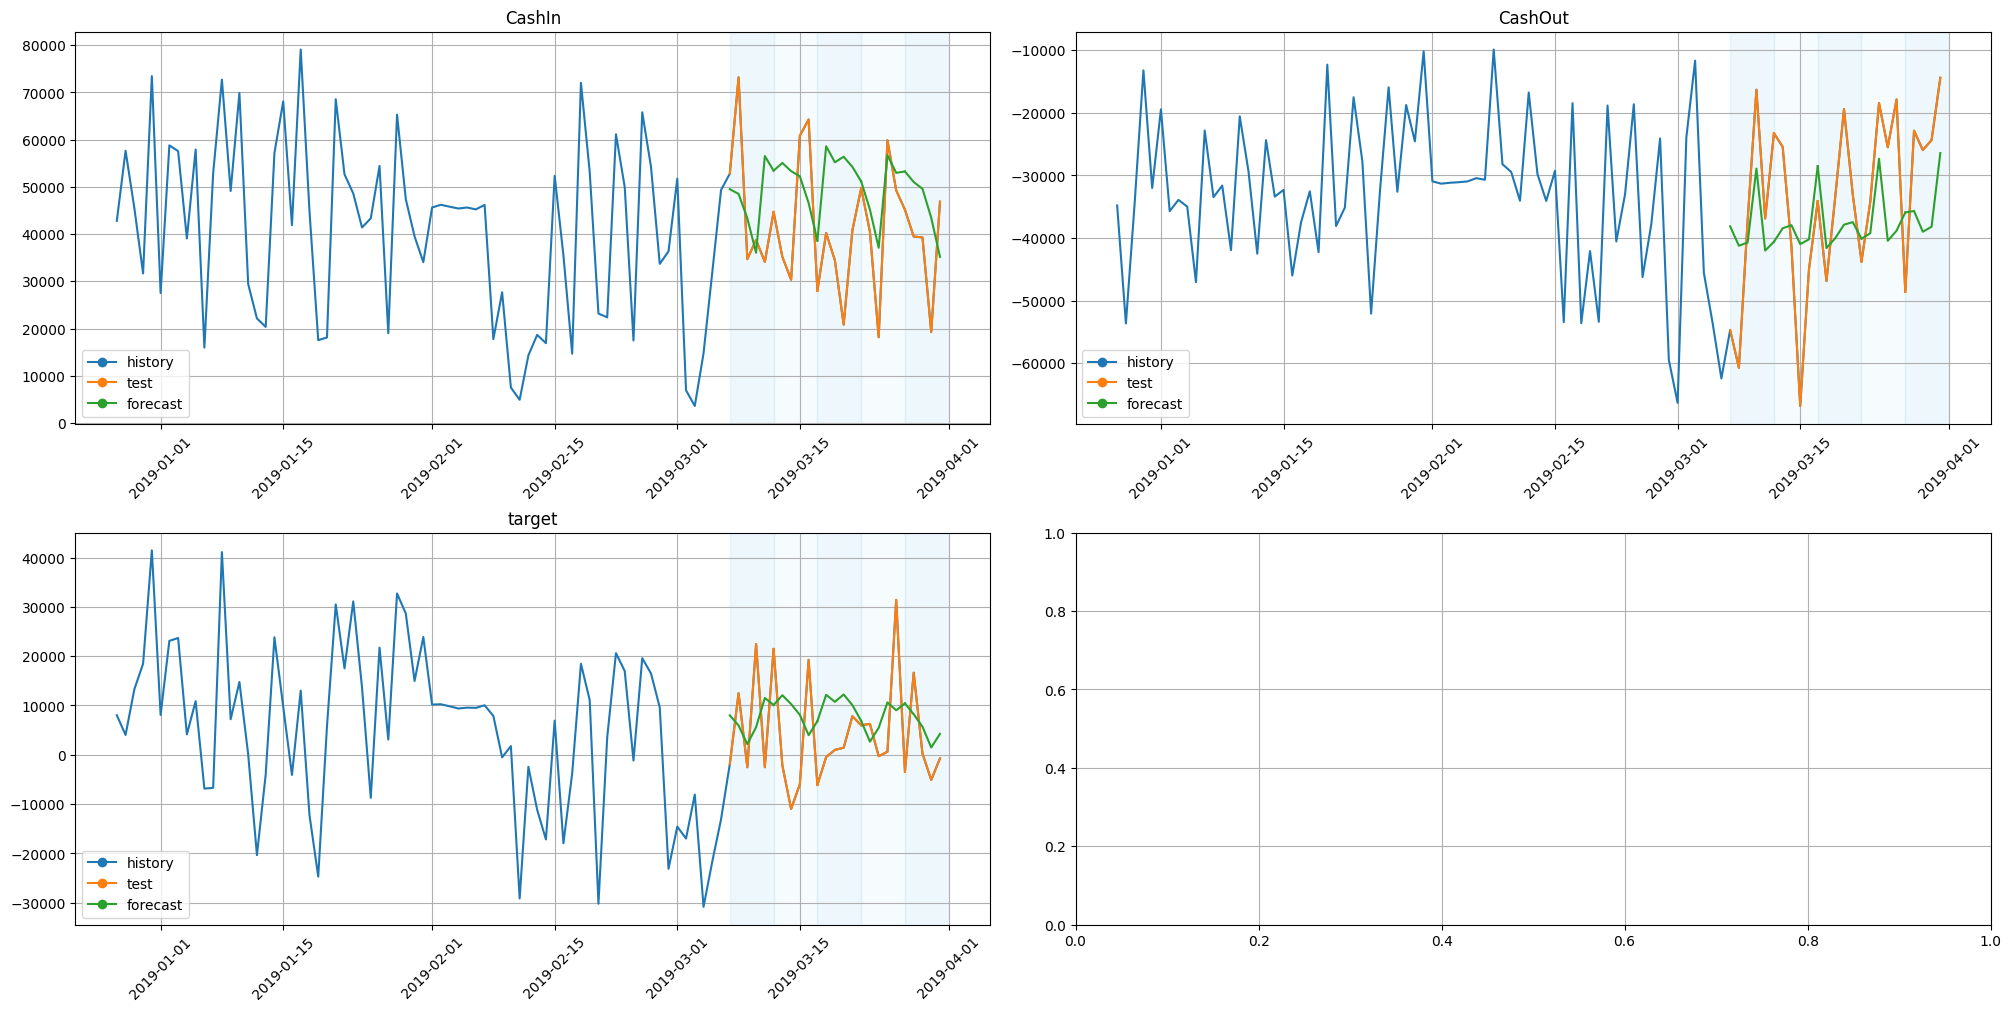

In [47]:
plot_backtest(forecast_df, ts, history_len=70)

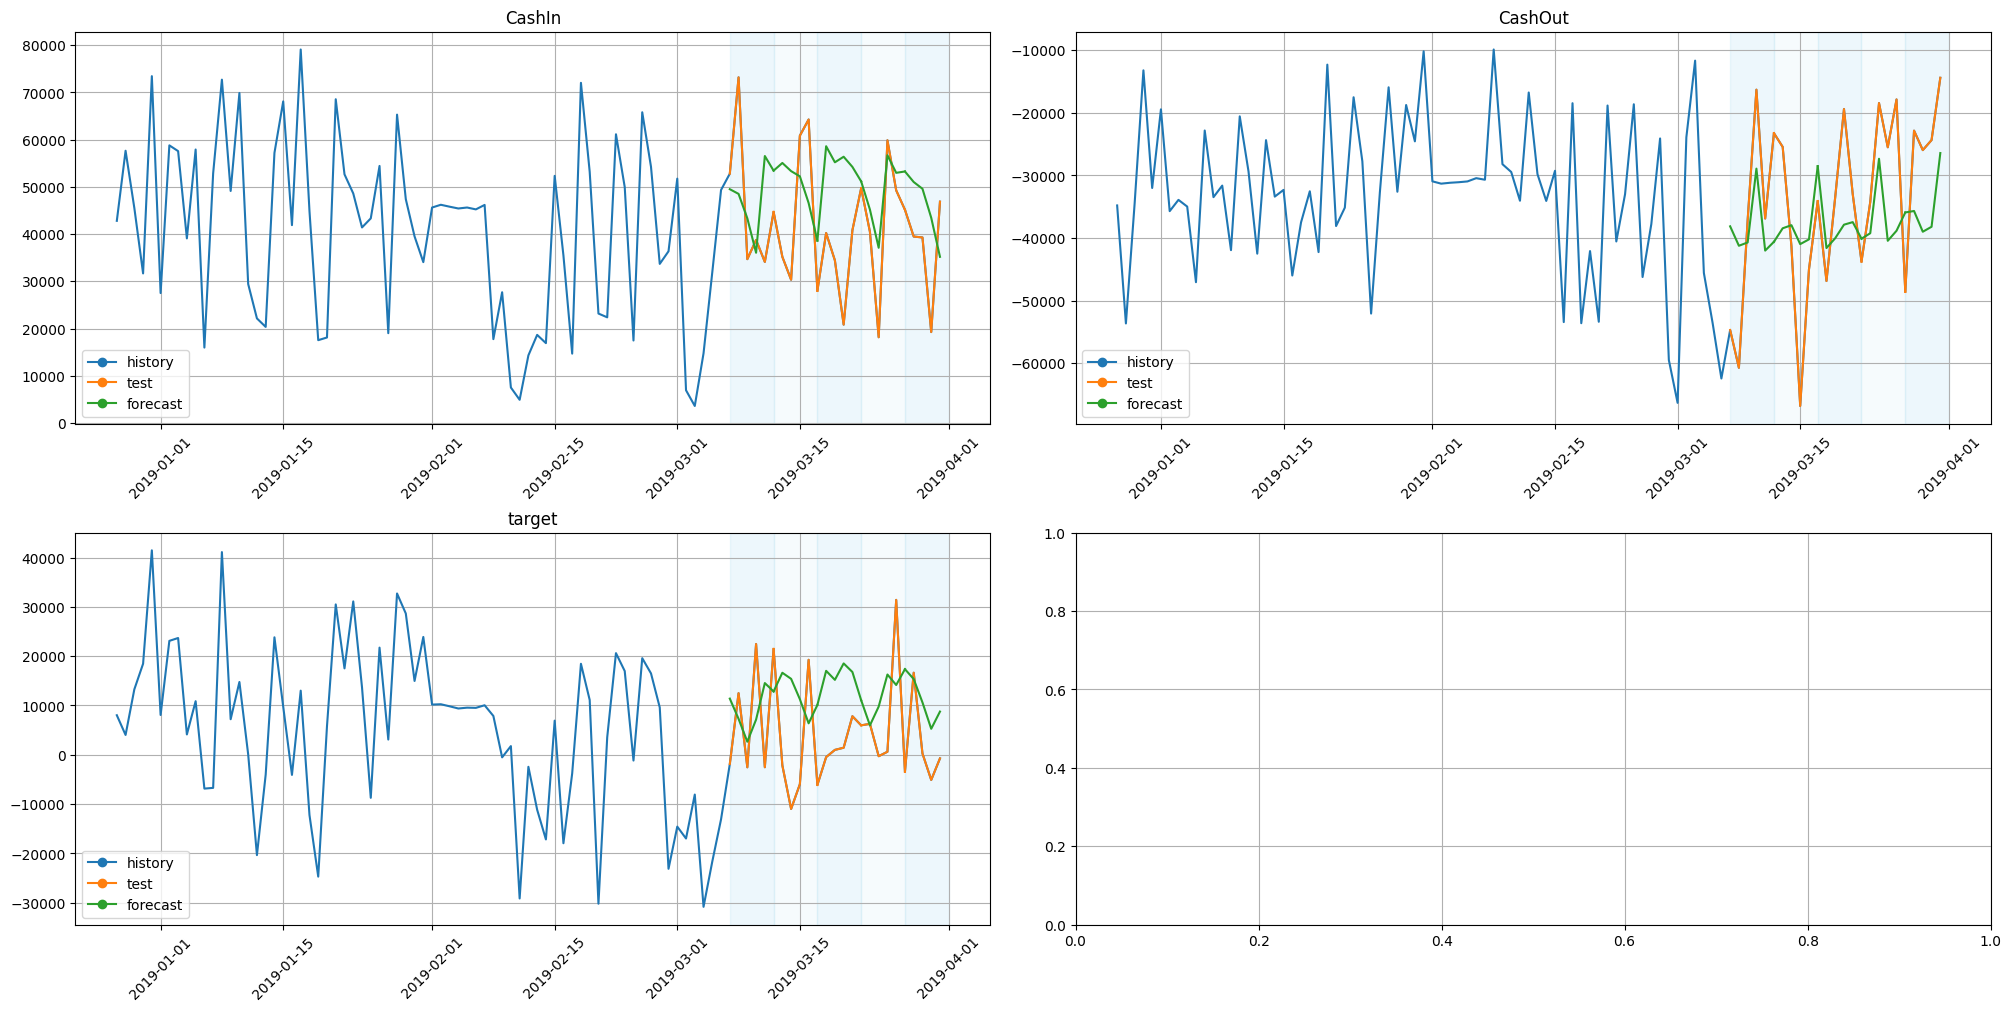

In [48]:
plot_backtest(new_forecast_df, ts, history_len=70)

In [49]:
ts['2019-03-07':, 'target', 'target'].to_numpy().shape

(25,)

In [50]:
new_forecast_df['target','target'].to_numpy().shape

(25,)

In [51]:
mae =sk.metrics.mean_absolute_error(ts['2019-03-07':, 'target', 'target'].to_numpy(), 
                                                  new_forecast_df['target','target'].to_numpy())
smape = sk.metrics.mean_absolute_percentage_error(ts['2019-03-07':, 'target', 'target'].to_numpy(), 
                                                  new_forecast_df['target','target'].to_numpy())
print("MAE = ", mae, "SMAPE=", smape)

MAE =  12584.410119361424 SMAPE= 8.8395448532635


Исходя из статистики по каждому ряду, какой можно сделать вывод о том, как лучше предсказывать итоговое значение? Посчитайте то же самое исходя из MAE.

Не очень похоже что, есть серьезная разница в предсказании уже таргета или отдельно пополненния/изъятия. Smape и правда ниже, однако здесь я думаю разница в том, что порядок значений предсказаний во втором случае больше, и получается что каждое слагаемое в Smape делится на большое значение. 

### Задание 5. Иерархический временной ряд (2 балла)

Вопрос, поставленный в прошлом задании, тем не менее, естественным образом подводит нас к концепции **иерархического временного ряда** (когда один ряд состоит из других в качестве компонент). Это полезная концепция, которая может встретиться во многих задачах. В этом задании вам предстоит самостоятельно разобраться в деталях ее реализации в ETNA с использованием справочных материалов, предоставляемых библиотекой (как это часто бывает на практике). Они содержатся по следующей ссылке:

https://github.com/tinkoff-ai/etna/blob/master/examples/hierarchical_pipeline.ipynb

На выходе из первой части задания необходимо получить `TSDataset` с иерархической структурой, а также соответствующий реконсилятор, который позволит собирать искомый ряд из составных компонент. Классы, которые вам понадобятся, импортированы ниже.

In [52]:
from etna.datasets import HierarchicalStructure
from etna.pipeline import HierarchicalPipeline
from etna.reconciliation import BottomUpReconciliator

In [53]:
hierarchical_structure = HierarchicalStructure(
    level_structure={"total": ["CashOut", "CashIn"]}, level_names=["total", "reason"]
)

hierarchical_structure

HierarchicalStructure(level_structure = {'total': ['CashOut', 'CashIn']}, level_names = ['total', 'reason'], )

In [54]:
df_copy.head()

timestamp   CashIn  CashOut   target
4 2016-01-05  20840.0 -22200.0  -1360.0
5 2016-01-06  28460.0 -18810.0   9650.0
6 2016-01-07  19250.0 -23210.0  -3960.0
7 2016-01-08  49770.0  -4350.0  45420.0
8 2016-01-09      NaN      NaN      NaN

In [55]:
df_h = df_copy.iloc[:,:3]

In [56]:
df_h = pd.melt(df_copy, id_vars=['timestamp'], value_vars=['CashIn','CashOut'],var_name='segment', value_name='target')
df_h.head()

timestamp segment   target
0 2016-01-05  CashIn  20840.0
1 2016-01-06  CashIn  28460.0
2 2016-01-07  CashIn  19250.0
3 2016-01-08  CashIn  49770.0
4 2016-01-09  CashIn      NaN

In [57]:
hierarchical_df = TSDataset.to_dataset(df=df_h)
hierarchical_df.head()

segment      CashIn  CashOut
feature      target   target
timestamp                   
2016-01-05  20840.0 -22200.0
2016-01-06  28460.0 -18810.0
2016-01-07  19250.0 -23210.0
2016-01-08  49770.0  -4350.0
2016-01-09      NaN      NaN

In [388]:
hierarchical_ts = TSDataset(df=hierarchical_df, freq="D", hierarchical_structure=hierarchical_structure)
hierarchical_ts.head()

segment      CashIn  CashOut
feature      target   target
timestamp                   
2016-01-05  20840.0 -22200.0
2016-01-06  28460.0 -18810.0
2016-01-07  19250.0 -23210.0
2016-01-08  49770.0  -4350.0
2016-01-09      NaN      NaN

In [393]:
hierarchical_ts.get_level_dataset(target_level="total")

segment       total
feature      target
timestamp          
2016-01-05  -1360.0
2016-01-06   9650.0
2016-01-07  -3960.0
2016-01-08  45420.0
2016-01-09      NaN
...             ...
2019-03-27  -3440.0
2019-03-28  16640.0
2019-03-29  44310.0
2019-03-30  -5100.0
2019-03-31  32470.0

[1182 rows x 1 columns]

In [390]:
hierarchical_ts.hierarchical_structure.level_names

['total', 'reason']

Во второй части задания примените найденные на предыдущих этапах преобразования очистку от аутлаеров уже к иерархическому датасету, и запустите на нем Prophet с MAE на кросс-валидации.

In [397]:
best_params = {"window_size": 16, "distance_coef": 0.8,"n_neighbors":7}

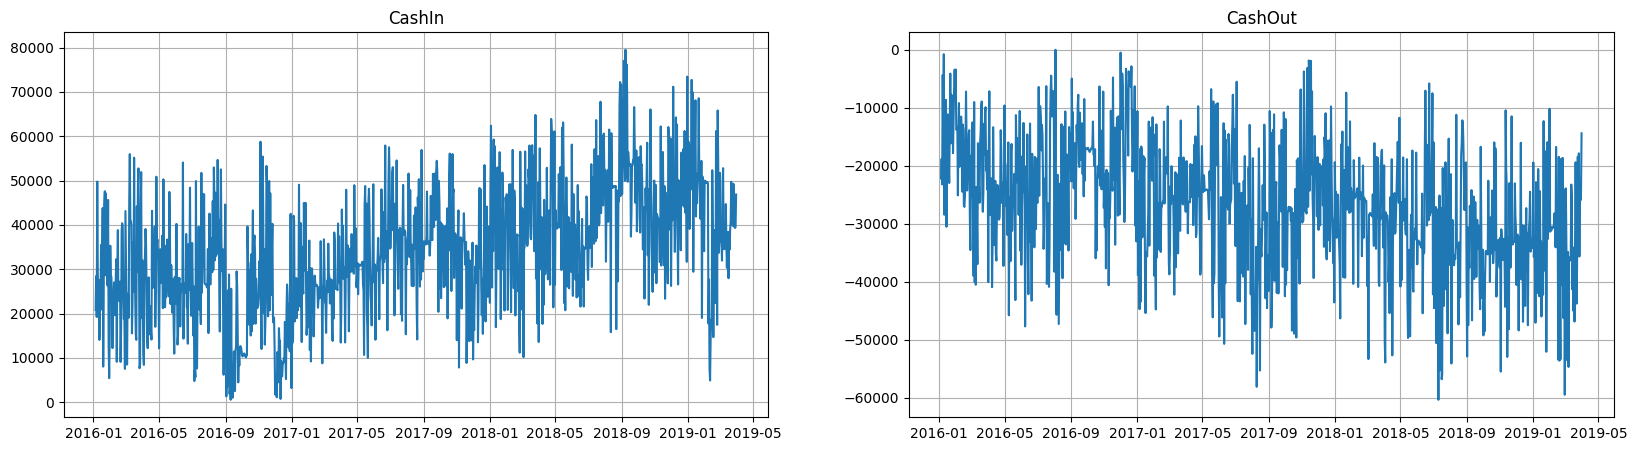

In [398]:
outliers_remover = DensityOutliersTransform(in_column="target", **best_params)
# Impute NaNs using the specified strategy
outliers_imputer = TimeSeriesImputerTransform(
    in_column="target", strategy="running_mean", window=30
)
hierarchical_ts.fit_transform([outliers_remover, outliers_imputer])
hierarchical_ts.plot()

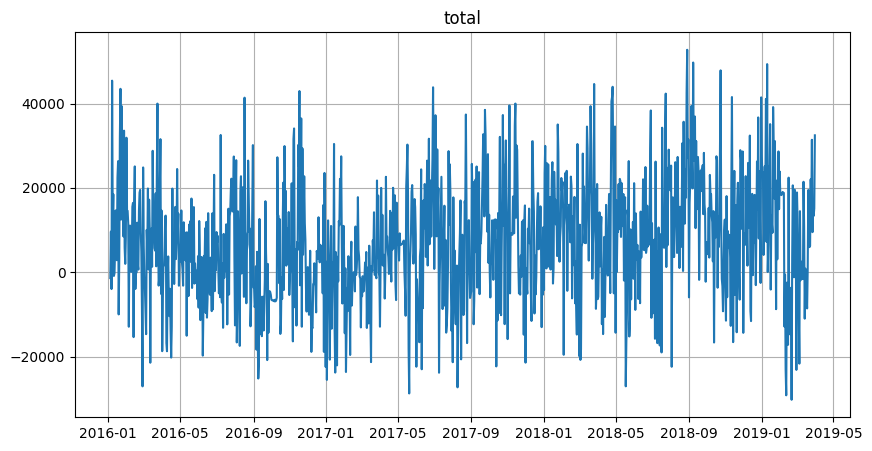

In [399]:
hierarchical_ts.get_level_dataset(target_level="total").plot()

In [438]:
reconciliator = BottomUpReconciliator(target_level="total", source_level="reason")


In [439]:
reconciliator.fit(ts=hierarchical_ts)
reconciliator.mapping_matrix.toarray()

array([[1, 1]])

In [445]:
model = ProphetModel()  # будем использовать Prophet
transforms = []  # пока оставим пустым
pipeline = HierarchicalPipeline(model=model, transforms=transforms, 
                                horizon=HORIZON,
                                reconciliator = BottomUpReconciliator(target_level="total", source_level="reason")) 

In [456]:
metrics_df, forecast_df, fold_info_df = pipeline.backtest(
    ts=hierarchical_ts,n_folds =10, metrics=[MAE()],aggregate_metrics=True
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
18:30:11 - cmdstanpy - INFO - Chain [1] start processing
18:30:11 - cmdstanpy - INFO - Chain [1] done processing
18:30:11 - cmdstanpy - INFO - Chain [1] start processing
18:30:11 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s
18:30:14 - cmdstanpy - INFO - Chain [1] start processing
18:30:14 - cmdstanpy - INFO - Chain [1] done processing
18:30:15 - cmdstanpy - INFO - Chain [1] start processing
18:30:15 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.1s remaining:    0.0s
18:30:17 - cmdstanpy - INFO - Chain [1] start processing
18:30:17 - cmdstanpy - INFO - Chain [1] done processing
18:30:17 - cmdstanpy - INFO - Chain [1] start processing
18:30:17 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.7s remaining:    0.0s
1

In [457]:
metrics_df.head(10)

segment           MAE
0   total  14755.353713

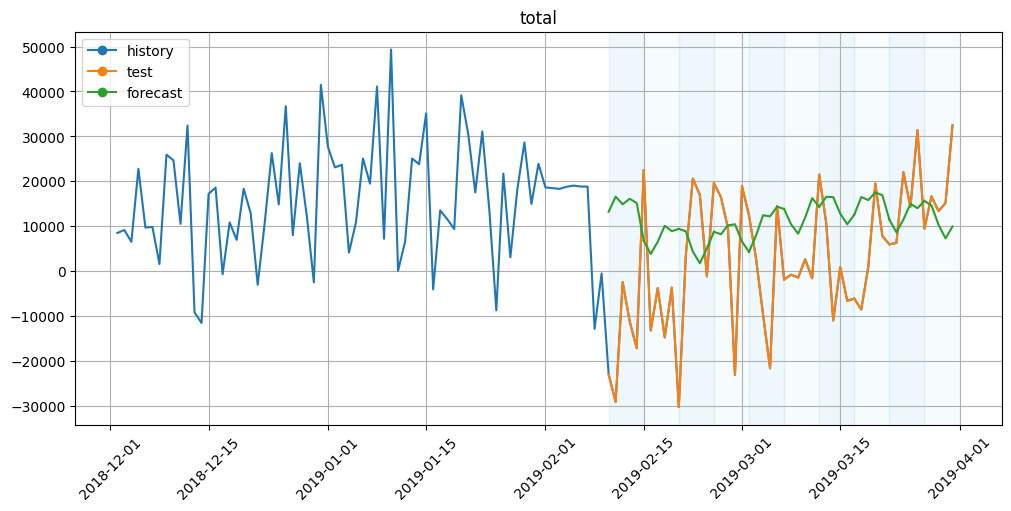

In [458]:
plot_backtest(forecast_df, hierarchical_ts.get_level_dataset(target_level="total"), history_len=70)

### Задание 6. Построение признаков (1.5 балла)

Вернемся к нашему исходному мультисегментному ряду - теперь поработаем с моделями, которые требуют построения признаков - `ARIMA` и `CatBoost`. Построим для них признаки, и попробуем при помощи них добиться улучшения качества. Из обязательного: 1) постройте графики автокорреляции и при помощи них обоснуйте выбор лаговых признаков 2) для катбуста включите в признаки результаты STL разложения. Кроме этого, подумайте на экспертном уровне, какие закономерности могут присутствовать в пополнени наличности из банкомата? Снятии? Что из этого кажется более предсказуемым, и почему? Cделайте соответствующие признаки, и снабдите их кратким комментарием.

После этого, обучите на получившихся признаках модели.

Ниже приведены импорты, которые вам точно понадобятся - к ним необходимо добавить те инструменты, которые вы дополнительно решите использовать в анализе.

In [58]:
from etna.analysis import sample_acf_plot, sample_pacf_plot, stl_plot
from etna.ensembles import DirectEnsemble, StackingEnsemble, VotingEnsemble
from etna.models import (CatBoostMultiSegmentModel, CatBoostModelPerSegment,
                         AutoARIMAModel)
from etna.transforms import STLTransform, LagTransform, SegmentEncoderTransform

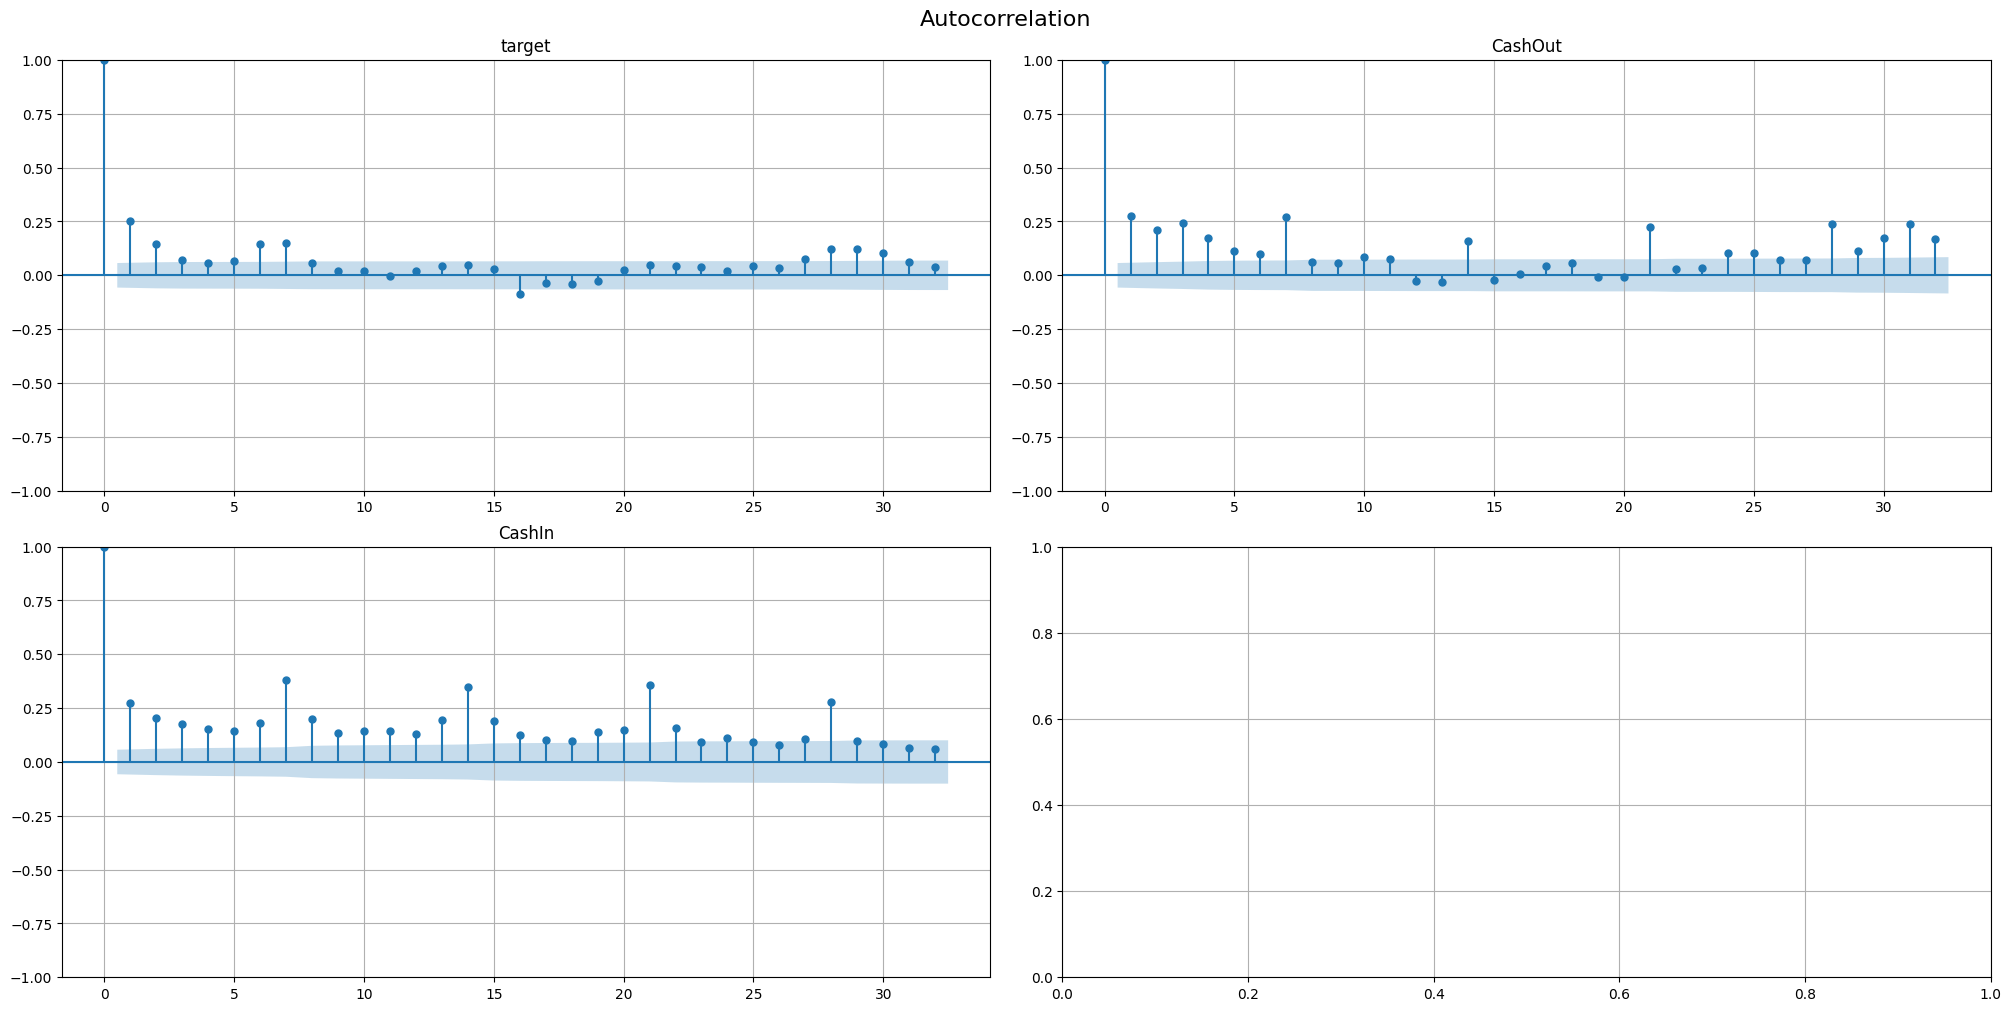

In [1046]:
sample_acf_plot(ts, lags=32)

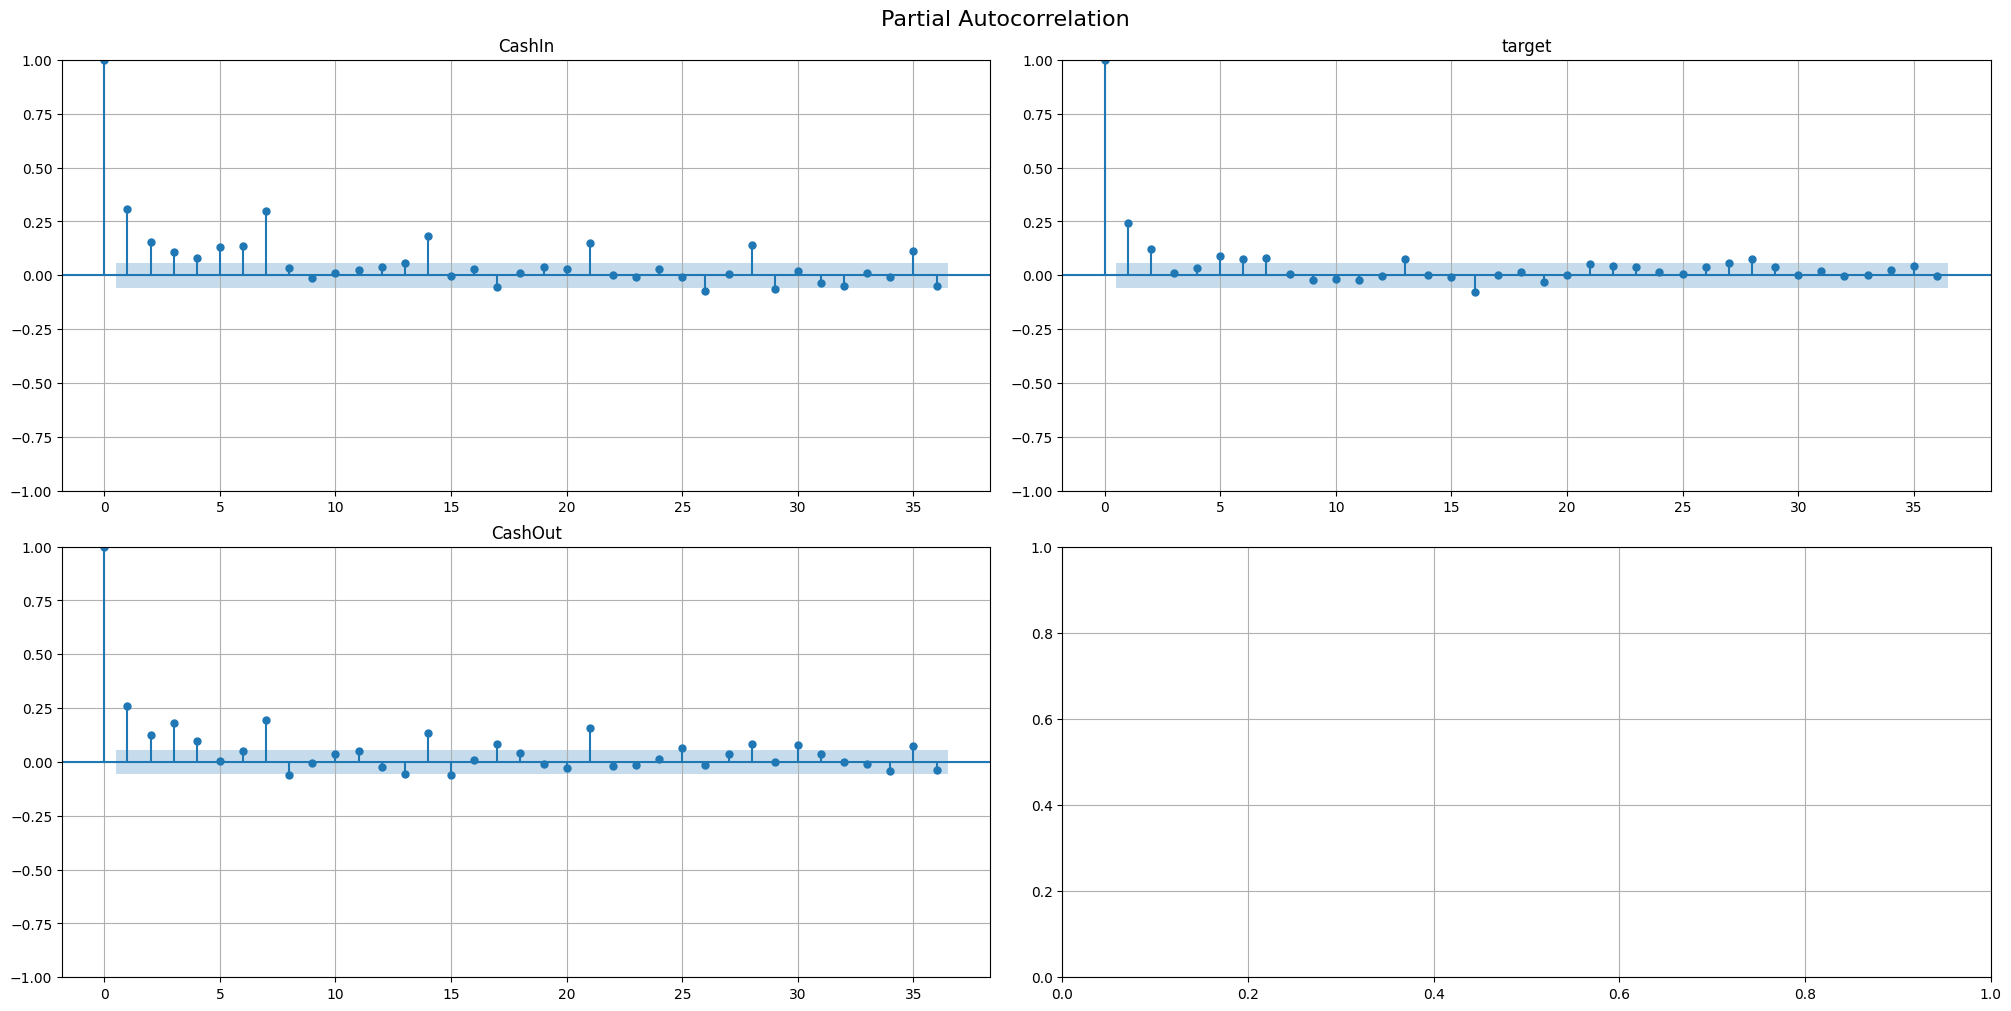

In [1047]:
sample_pacf_plot(ts_n, lags=36)

In [61]:
ts_n = deepcopy(ts)

In [941]:
lags = LagTransform(in_column="target", lags=[1,2,7,14,21], out_column="lag")
stl_trans = STLTransform(in_column="target", period=7, model="arima")
seg = SegmentEncoderTransform()
mean30 = MeanTransform(in_column="target", window=30,out_column="mean30")
hol = HolidayTransform(iso_code="TUR", out_column="TUR_holidays")
dt_flag = DateFlagsTransform(
        day_number_in_week=True,
        day_number_in_month=True,
        is_weekend=True,
        special_days_in_week=[2],
        out_column="date_flag",
    )
time_ser = TimeSeriesImputerTransform(in_column="target", window=30, strategy = "mean")
ts_n.fit_transform([seg,time_ser,lags,stl_trans,mean30,hol,dt_flag])
ts_n.head()

segment          CashIn                                \
feature    TUR_holidays date_flag_day_number_in_month   
timestamp                                               
2016-01-05            0                             5   
2016-01-06            0                             6   
2016-01-07            0                             7   
2016-01-08            0                             8   
2016-01-09            0                             9   

segment                                                       \
feature    date_flag_day_number_in_week date_flag_is_weekend   
timestamp                                                      
2016-01-05                            1                False   
2016-01-06                            2                False   
2016-01-07                            3                False   
2016-01-08                            4                False   
2016-01-09                            5                 True   

segment                                                                    \
feature    date_flag_special_days_in_week    lag_1 lag_14    lag_2 lag_21   
timestamp                                                                   
2016-01-05                          False      NaN    NaN      NaN    NaN   
2016-01-06                           True  20840.0    NaN      NaN    NaN   
2016-01-07                          False  28460.0    NaN  20840.0    NaN   
2016-01-08                          False  19250.0    NaN  28460.0    NaN   
2016-01-09                          False  49770.0    NaN  19250.0    NaN   

segment           ...               target                                 \
feature    lag_7  ... date_flag_is_weekend date_flag_special_days_in_week   
timestamp         ...                                                       
2016-01-05   NaN  ...                False                          False   
2016-01-06   NaN  ...                False                           True   
2016-01-07   NaN  ...                False                          False   
2016-01-08   NaN  ...                False                          False   
2016-01-09   NaN  ...                 True                          False   

segment                                                                        \
feature           lag_1 lag_14   lag_2 lag_21 lag_7       mean30 segment_code   
timestamp                                                                       
2016-01-05          NaN    NaN     NaN    NaN   NaN  8275.875787            2   
2016-01-06 -1360.000000    NaN     NaN    NaN   NaN  4216.278571            2   
2016-01-07  9650.000000    NaN -1360.0    NaN   NaN   111.175857            2   
2016-01-08 -3960.000000    NaN  9650.0    NaN   NaN  -248.035489            2   
2016-01-09  1443.333333    NaN -3960.0    NaN   NaN   910.953324            2   

segment                  
feature          target  
timestamp                
2016-01-05  8275.875787  
2016-01-06   156.681354  
2016-01-07 -8099.029570  
2016-01-08 -1325.669526  
2016-01-09  5546.908574  

[5 rows x 39 columns]

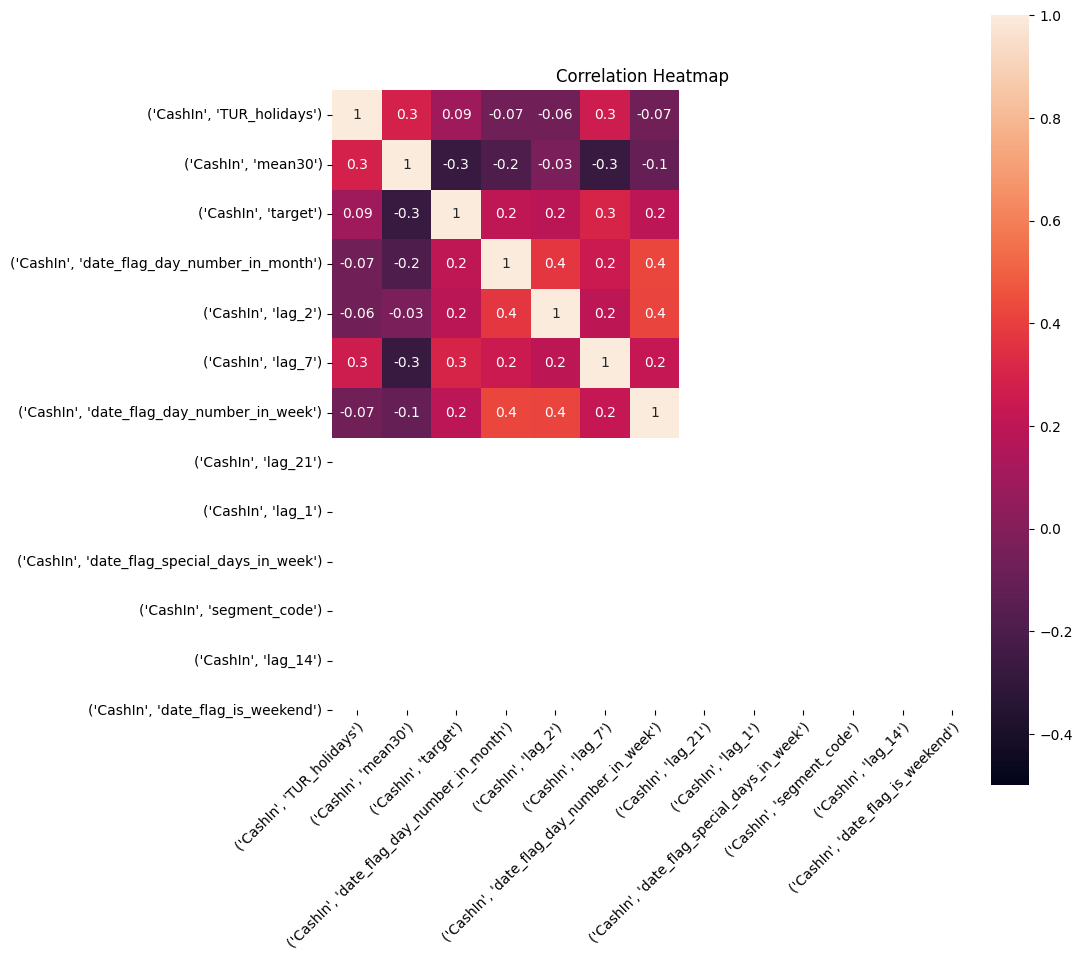

In [929]:
plot_correlation_matrix(
    ts_n, segments=["CashIn"], method="spearman", vmin=-0.5, vmax=1
)

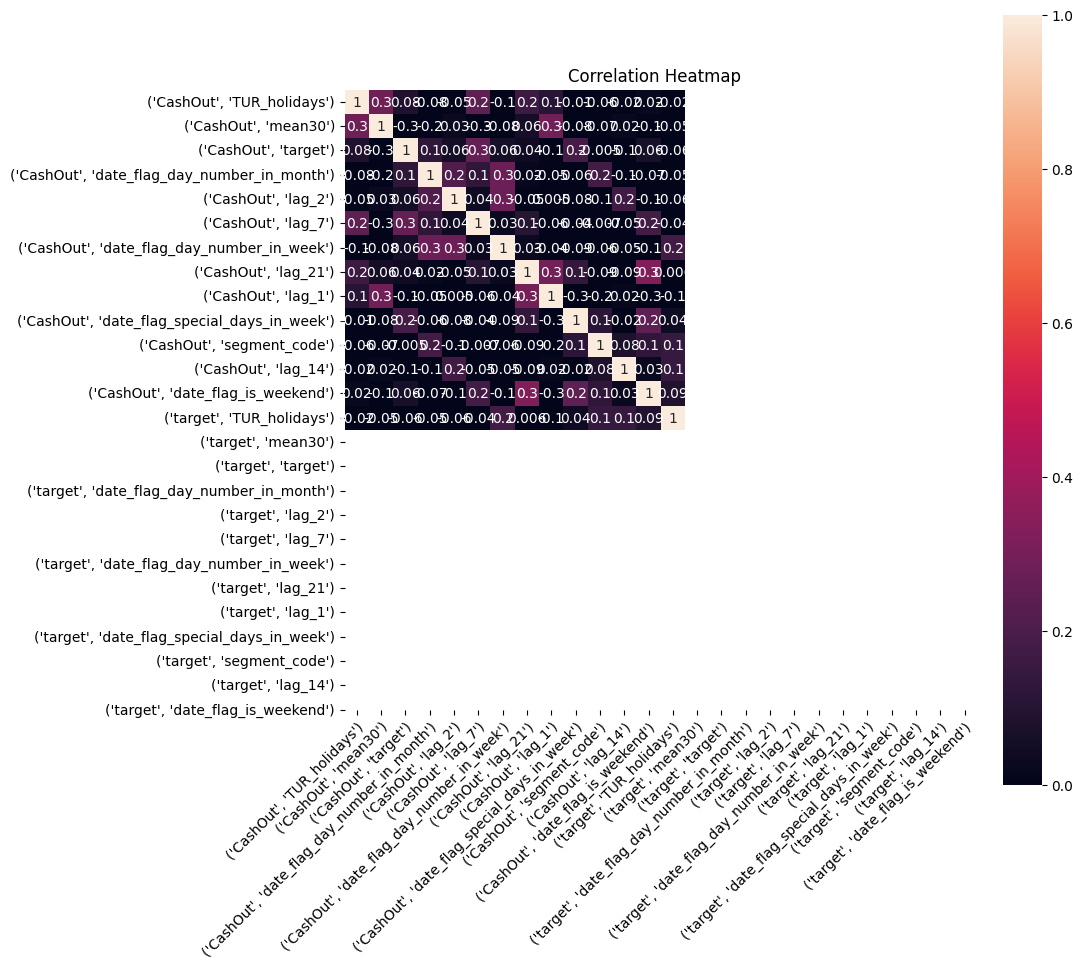

In [928]:
plot_correlation_matrix(
    ts_n, segments=["CashOut","target"], method="spearman", vmin=0, vmax=1
)

Я решил добавить признаки праздников в Турции, так как логично что большие снятия и следовательно необходимые дополнительные пополнения по идее должны приходится перед праздниками, когда многие люди закупают подарки и еду для застолья.
Также я добавил флаги дня в неделе и номе дня в месяце, так как вполне возможно, что люди снимают/кладут деньги после получения заработной платы. Также Я происледовал несколько месяцев в выборке, и почти каждый раз большие пополнения были в понедельник. Поэтому я и решил его выделить.
Также просто для лучше обучения добавил признак среднего по месяцу, так как валюта в турции довольно сильно флуктуирует между несколькими месяцами, поэтому я подумал, что это признак поможет лучше уловить эту зависимость.

In [62]:
transforms=[LagTransform(in_column="target", lags=[1,2,7,14,21,28], out_column="lag"),
                STLTransform(in_column="target", period=7, model="arima"),
                SegmentEncoderTransform(),
                MeanTransform(in_column="target", window=30,out_column="mean30"),
                HolidayTransform(iso_code="TUR", out_column="TUR_holidays"),
#                 DateFlagsTransform( special_days_in_week=[2],
#                                     out_column="date_flag" ),
                DateFlagsTransform( day_number_in_week=True,
                                    day_number_in_month=True,
                                    is_weekend=True,
                                    special_days_in_week=[2],
                                    out_column="date_flag" ),
#             TimeSeriesImputerTransform(in_column="target", window=30, strategy = "mean")
           ]

CatBoostMultiSeg_pipeline = Pipeline(
    model=CatBoostMultiSegmentModel(),
    transforms=transforms,
    horizon=HORIZON,
)
CatBoostPerSeg_pipeline = Pipeline(
    model=CatBoostModelPerSegment(),
    transforms=transforms,
    horizon=HORIZON,
)

pipeline_names = ["CB_MultiSegment", "CB_PerSegment"]
pipelines = [CatBoostMultiSeg_pipeline, CatBoostPerSeg_pipeline]

In [63]:
metrics = []
for pipeline in pipelines:
    metrics.append(
        [pipeline.backtest(
            ts=ts_n,
            metrics=[MAE(), SMAPE()],
            n_folds=5,
            aggregate_metrics=True,
        )]
    )

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   52.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  3.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  7.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  9.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elap

In [64]:
# metrics = pd.concat(metrics)
# metrics.index = pipeline_names
# forecast_catboost = deepcopy(ts)
# forecast_catboost["CashIn","target"]=metrics[0][0][1]["CashIn","target
metrics[0][0][0]

segment           MAE       SMAPE
0   CashIn  38553.562428   66.647028
1  CashOut  14014.210874   55.198377
2   target  32604.942087  162.468028

In [65]:
metrics[1][0][0]

segment           MAE       SMAPE
0   CashIn  29792.125195   58.215562
1  CashOut  13811.526838   56.785759
2   target  28054.120241  160.300804

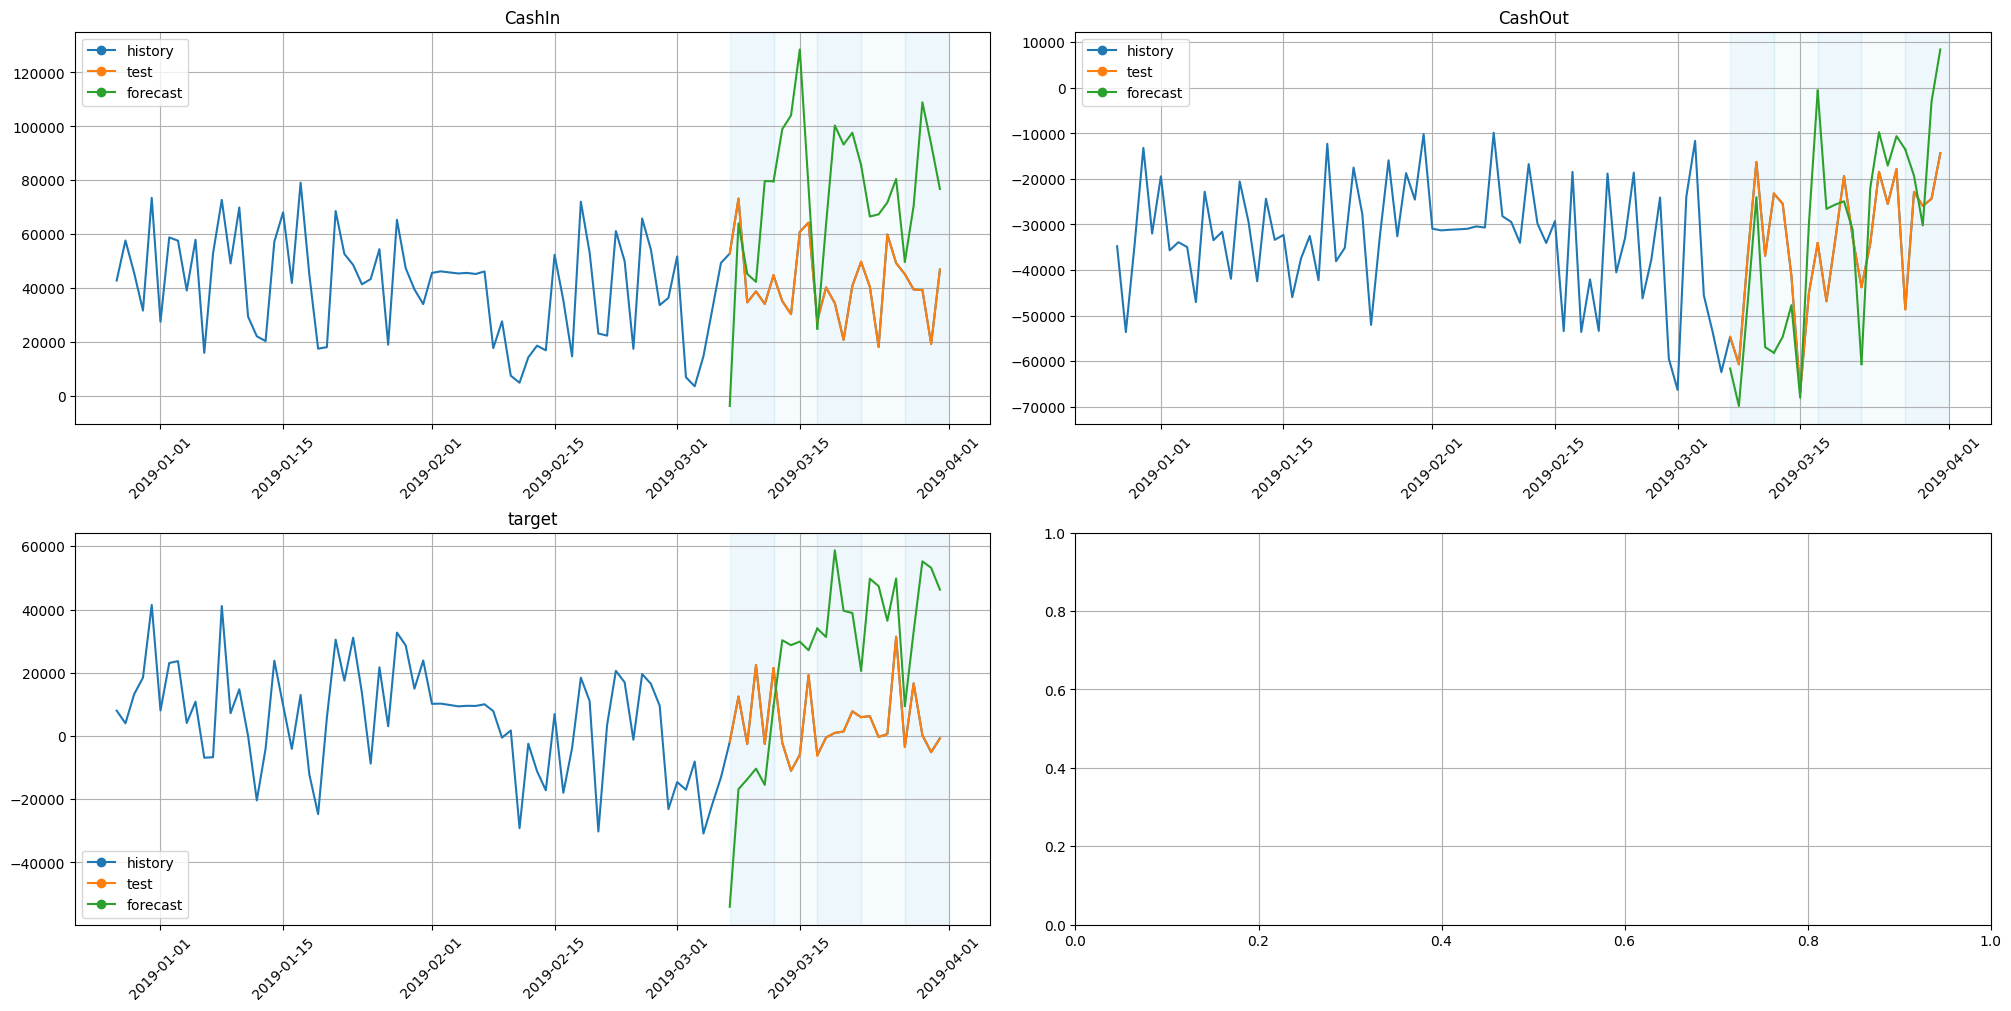

In [66]:
plot_backtest(metrics[0][0][1], ts_n, history_len=70)

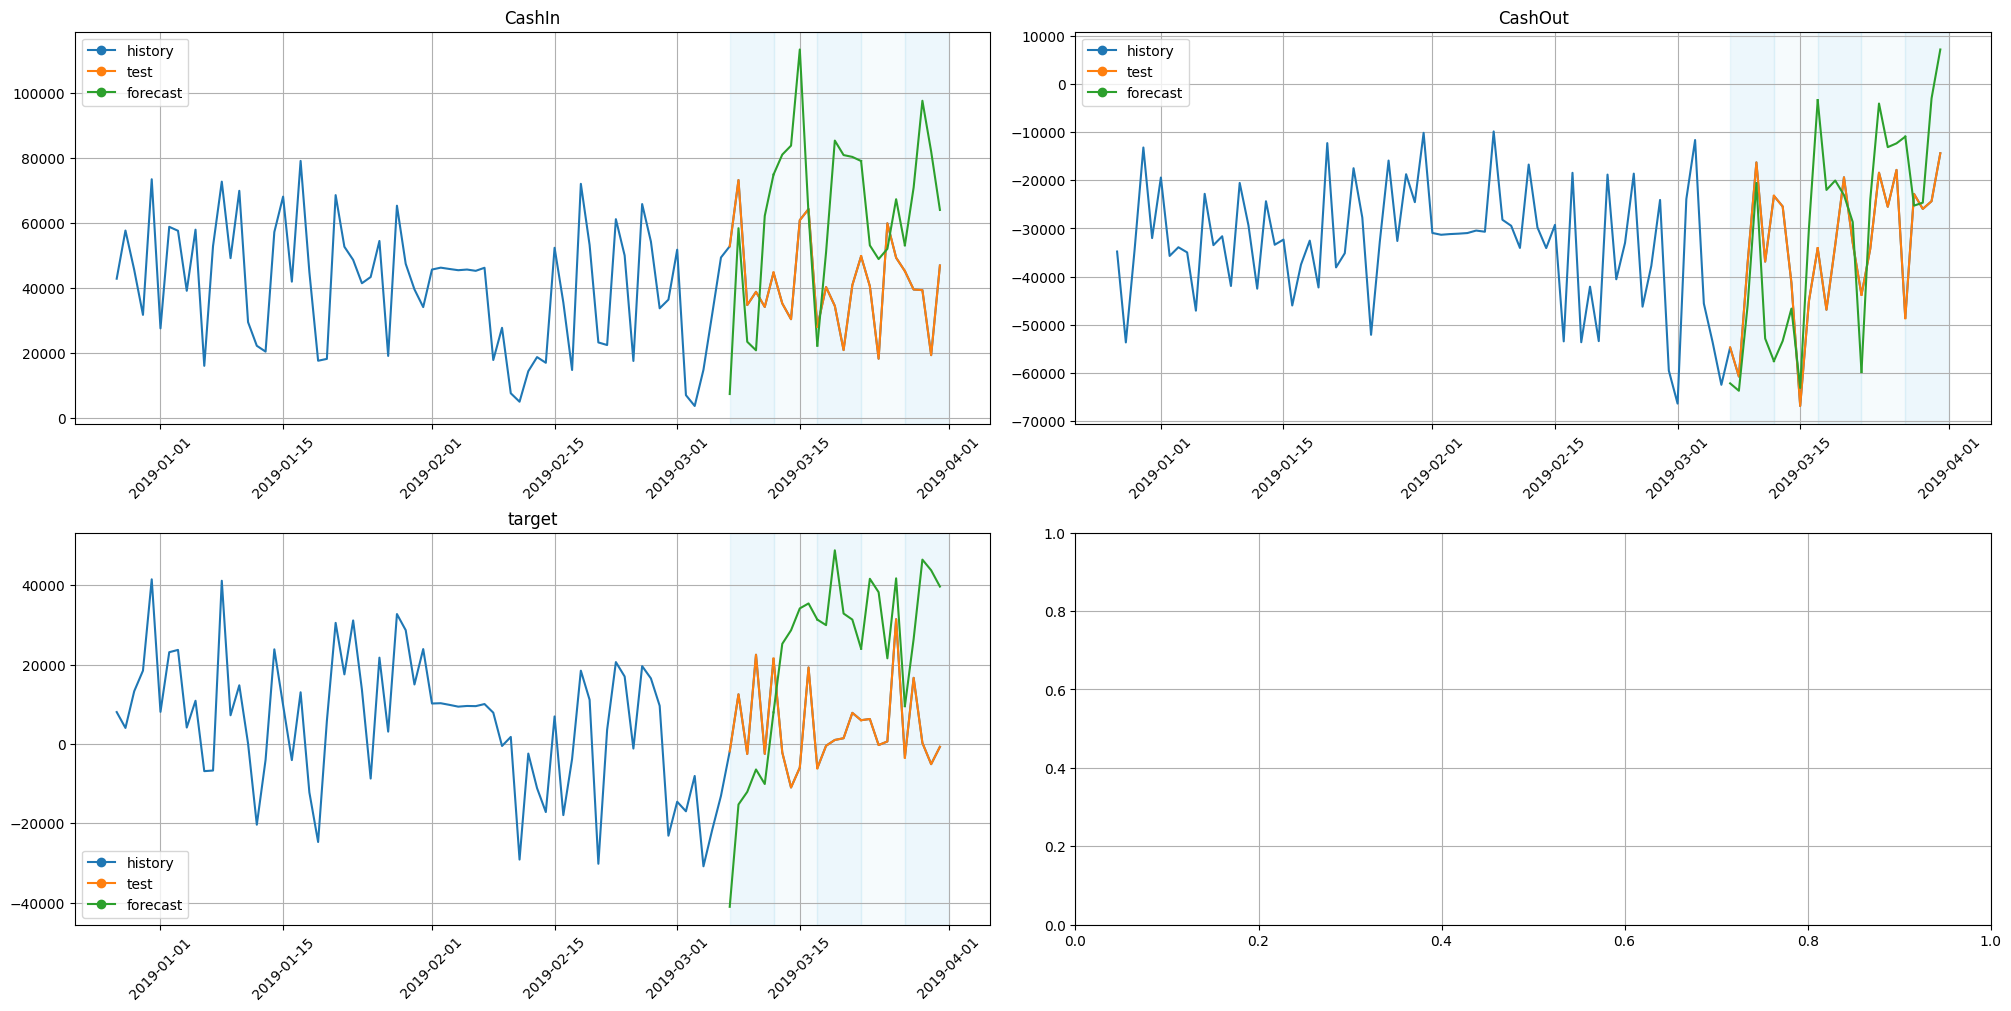

In [67]:
plot_backtest(metrics[1][0][1], ts_n, history_len=70)

In [68]:
transforms_ar=[
    LagTransform(in_column="target", lags=[23,24,28,30,31], out_column="lag"),
                STLTransform(in_column="target", period=7, model="arima"),
                SegmentEncoderTransform(),
                MeanTransform(in_column="target", window=30,out_column="mean30"),
                HolidayTransform(iso_code="TUR", out_column="TUR_holidays"),
#                 DateFlagsTransform( special_days_in_week=[2],
#                                     out_column="date_flag" ),
                DateFlagsTransform( day_number_in_week=True,
                                    day_number_in_month=True,
                                    is_weekend=True,
                                    special_days_in_week=[2],
                                    out_column="date_flag" ),
#             TimeSeriesImputerTransform(in_column="target", window=30, strategy = "mean")
           ]
AutoARIMA_pipeline = Pipeline(
    model=AutoARIMAModel(),
    transforms=transforms_ar,
    horizon=HORIZON,
)

In [69]:
metrics.append(
        [AutoARIMA_pipeline.backtest(
            ts=ts_n,
            metrics=[MAE(), SMAPE()],
            n_folds=4,
            aggregate_metrics=True,n_jobs=3
        )]
    )

[Parallel(n_jobs=3)]: Using backend MultiprocessingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:   41.7s
[Parallel(n_jobs=3)]: Done   2 out of   4 | elapsed:   49.9s remaining:   49.9s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed:  1.4min finished


In [70]:
metrics[-1][0][0]

segment           MAE       SMAPE
0   CashIn  17154.875870   39.696419
1  CashOut  13493.009654   40.563583
2   target  12249.648728  155.140089

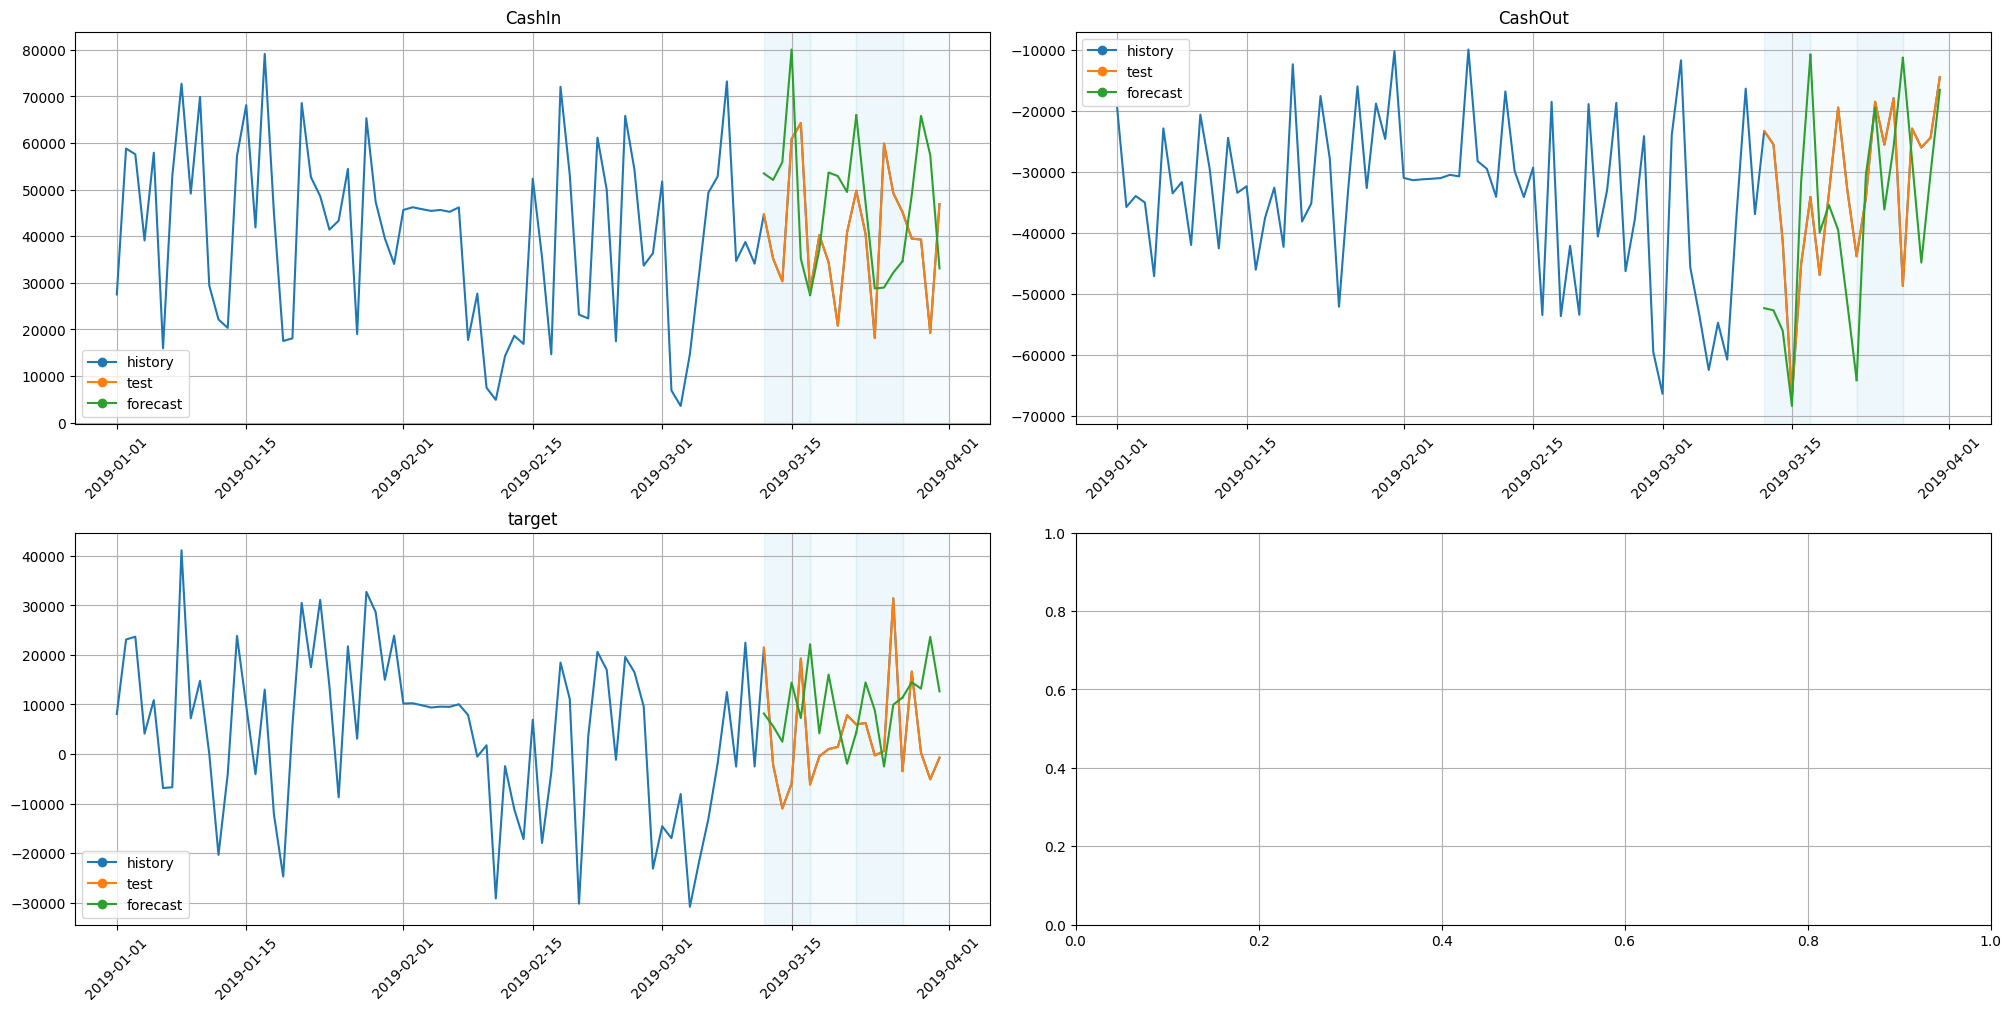

In [71]:
plot_backtest(metrics[-1][0][1], ts_n, history_len=70)

### Задание 7. Стратегии прогнозирования (1.25 балла)

Как нам известно по семинарским занятиям, при построении прогноза на горизонте дальше следующего наблюдения перед нами встает задача определиться со стратегией генерации прогноза. Попробуйте разные стратегии на нашем горизонте из 5 дней (прямая, рекурсивная, смешанная dirrec). Какая стратегия в совокупности с какой моделью дает лучший результат?

Учитывайте особенности, которые некоторые стратегии могут накладывать на признаки (в частности, на лаговые переменные).

При необходимости, в смешанном методе пользуйтесь упрощенной схемой спецификации моделей/преобразований.

In [72]:
from etna.pipeline import AutoRegressivePipeline, Pipeline, assemble_pipelines
from etna.ensembles import DirectEnsemble

In [73]:
CatBoostMultiSeg_AG_pipeline = AutoRegressivePipeline(
    model=CatBoostMultiSegmentModel(),
    transforms=transforms,
    horizon=HORIZON, step=1
)
CatBoostPerSeg_AG_pipeline = AutoRegressivePipeline(
    model=CatBoostModelPerSegment(),
    transforms=transforms,
    horizon=HORIZON, step=1
)
pipeline_names_AG = ["CB_MultiSegment_AG", "CB_PerSegment_AG","ARIMA_AG"]
pipelines_AG = [CatBoostMultiSeg_AG_pipeline, CatBoostPerSeg_AG_pipeline]

In [74]:
metrics_ag = []
for pipeline in pipelines_AG:
    metrics_ag.append(
        [pipeline.backtest(
            ts=ts_n,
            metrics=[MAE(), SMAPE()],
            n_folds=4,
            aggregate_metrics=True
        )]
    )

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   54.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  3.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  3.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  7.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 10.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 10.0min finished


In [75]:
AutoARIMA_AG_pipeline = AutoRegressivePipeline(
    model=AutoARIMAModel(),
    transforms=transforms,
    horizon=HORIZON,step=1
)

In [76]:
metrics_ag.append(
        [AutoARIMA_pipeline.backtest(
            ts=ts_n,
            metrics=[MAE(), SMAPE()],
            n_folds=4,
            aggregate_metrics=True
        )]
    )

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   35.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.8min finished


In [77]:
for i,ar in enumerate(metrics_ag):
    print(pipeline_names_AG[i])
    print(ar[0][0].head(10))
    print("\n")

CB_MultiSegment_AG
   segment           MAE       SMAPE
0   CashIn  18700.448592   43.021919
1  CashOut  14165.588400   47.958674
2   target  14532.069250  161.093540


CB_PerSegment_AG
   segment           MAE       SMAPE
0   CashIn  18560.374826   42.735783
1  CashOut  14411.930649   50.251431
2   target  15402.294384  157.190196


ARIMA_AG
   segment           MAE       SMAPE
0   CashIn  16874.511506   38.768536
1  CashOut  13493.009654   40.563583
2   target  12249.648728  155.140089




CB_MultiSegment_AG


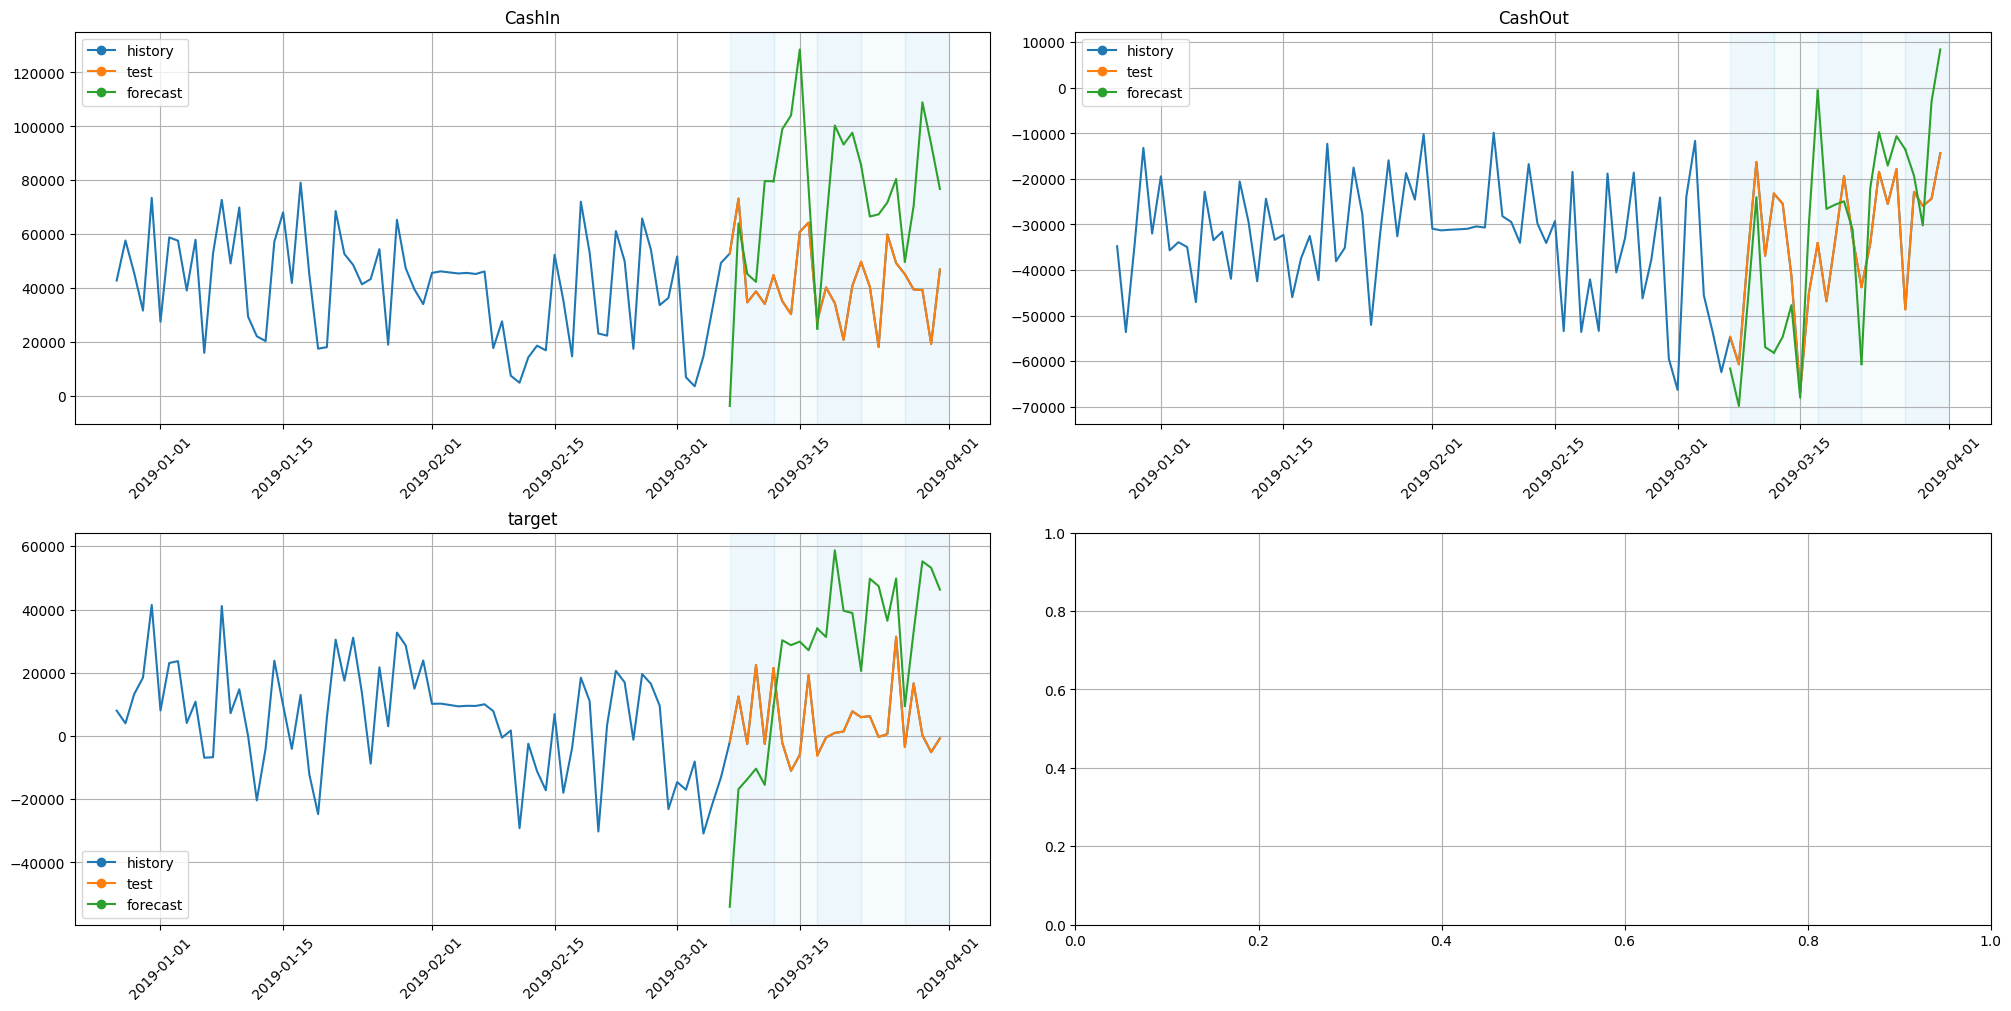

In [78]:
print(pipeline_names_AG[0])
plot_backtest(metrics[0][0][1],ts_n,history_len=70)

CB_PerSegment_AG


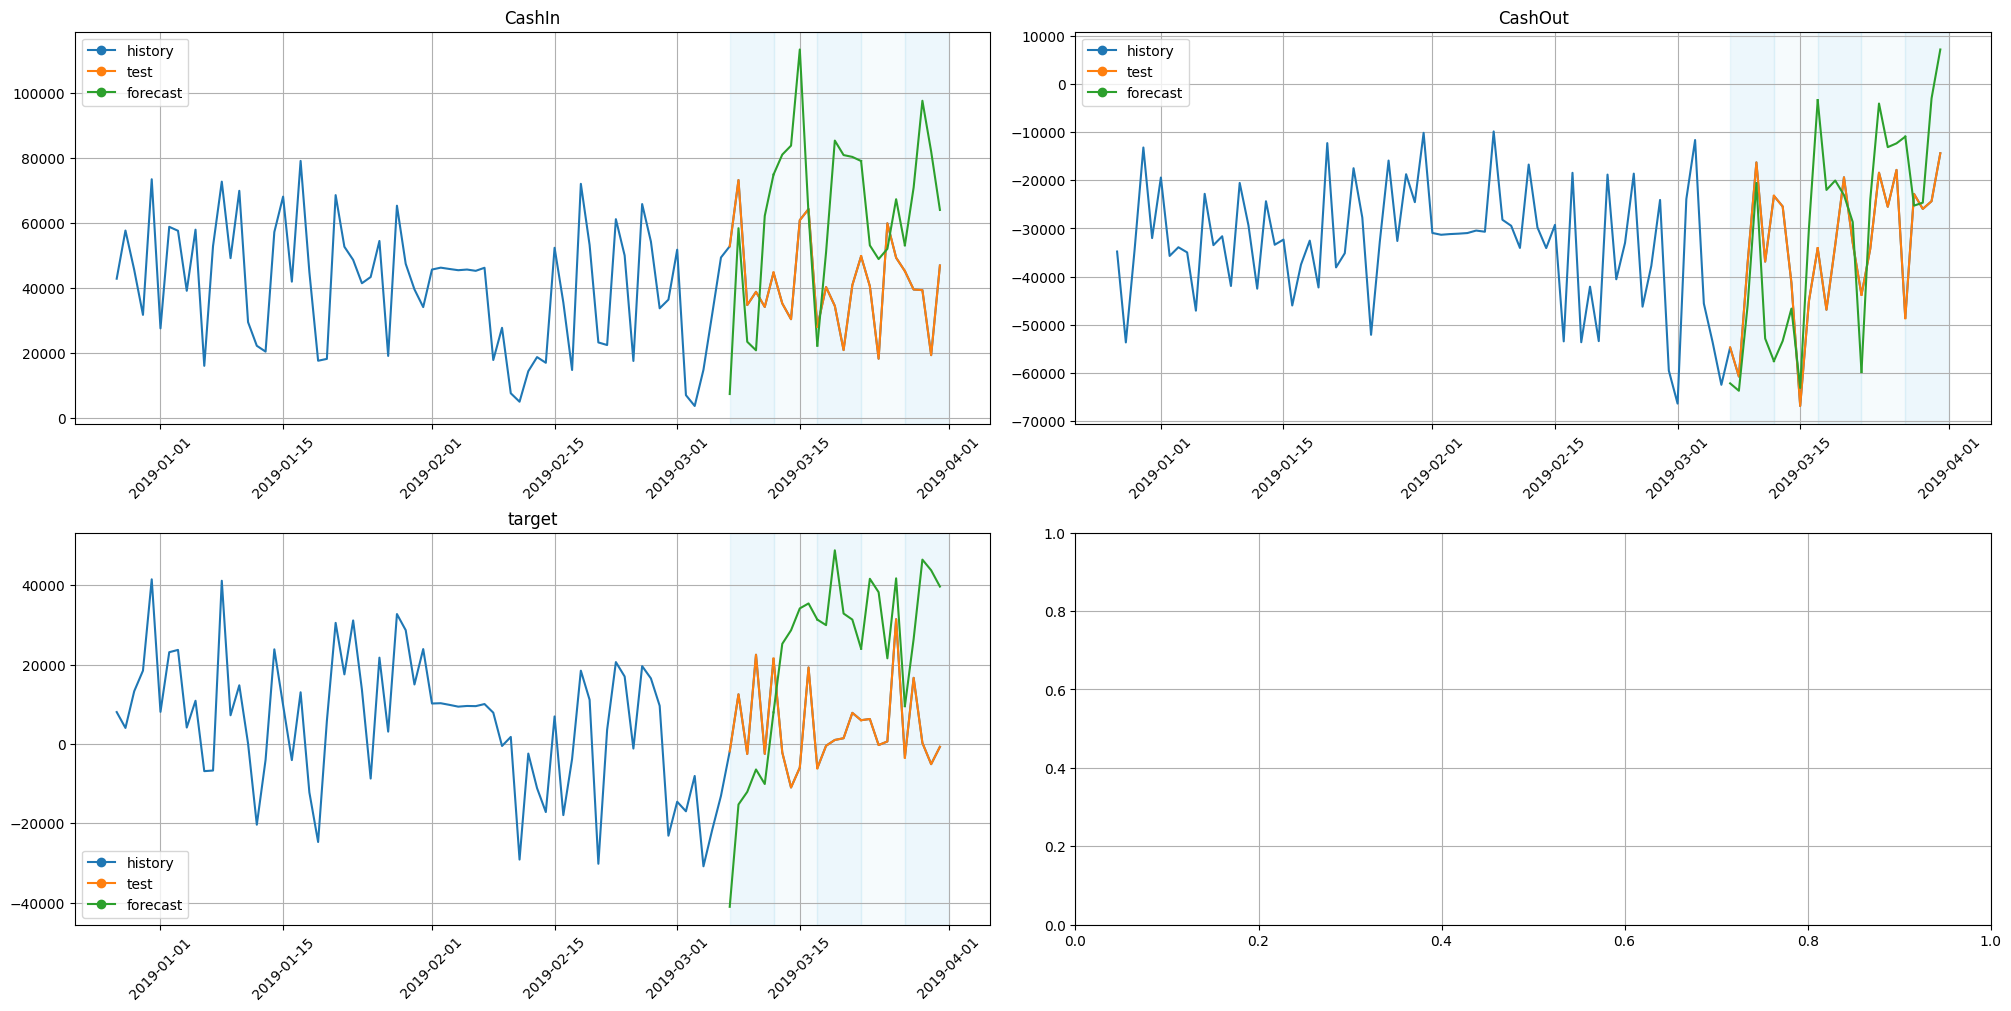

In [79]:
print(pipeline_names_AG[1])
plot_backtest(metrics[1][0][1],ts_n,history_len=70)

ARIMA_AG


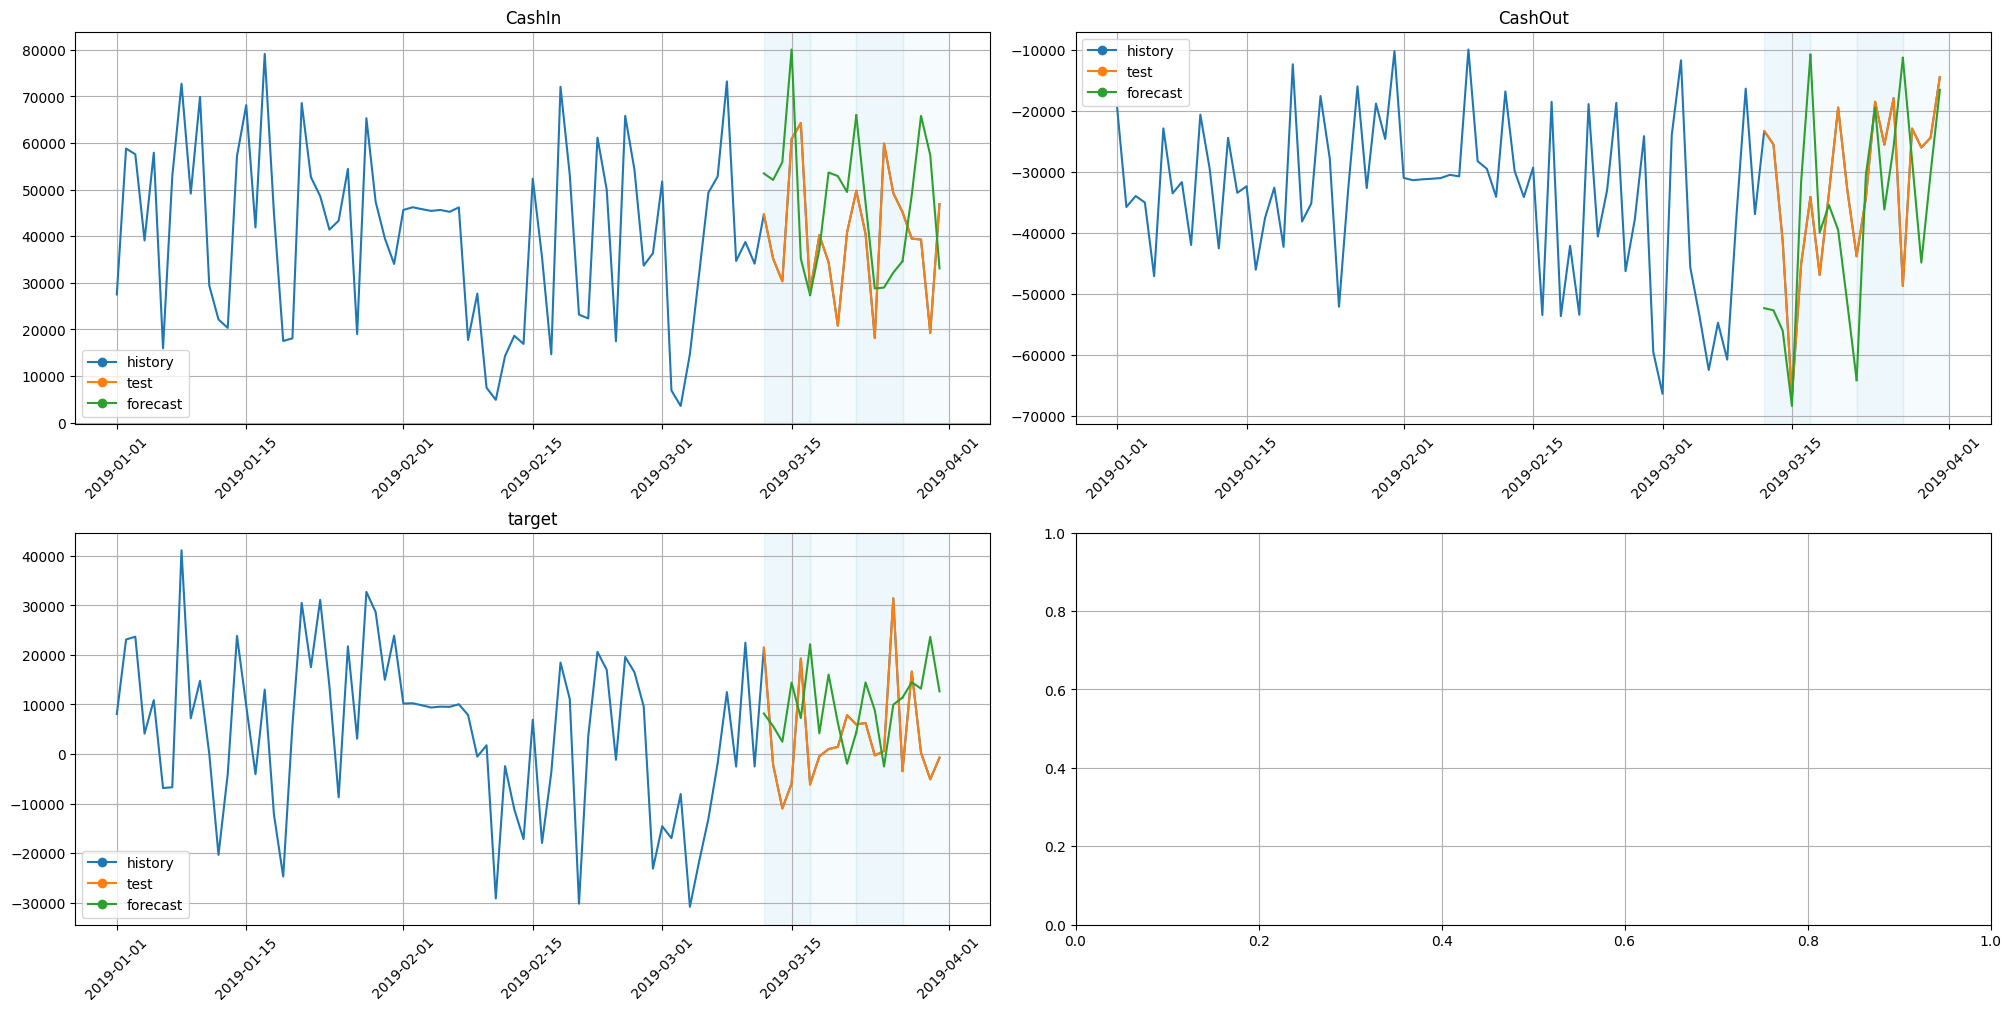

In [80]:
print(pipeline_names_AG[2])
plot_backtest(metrics[2][0][1],ts_n,history_len=70)

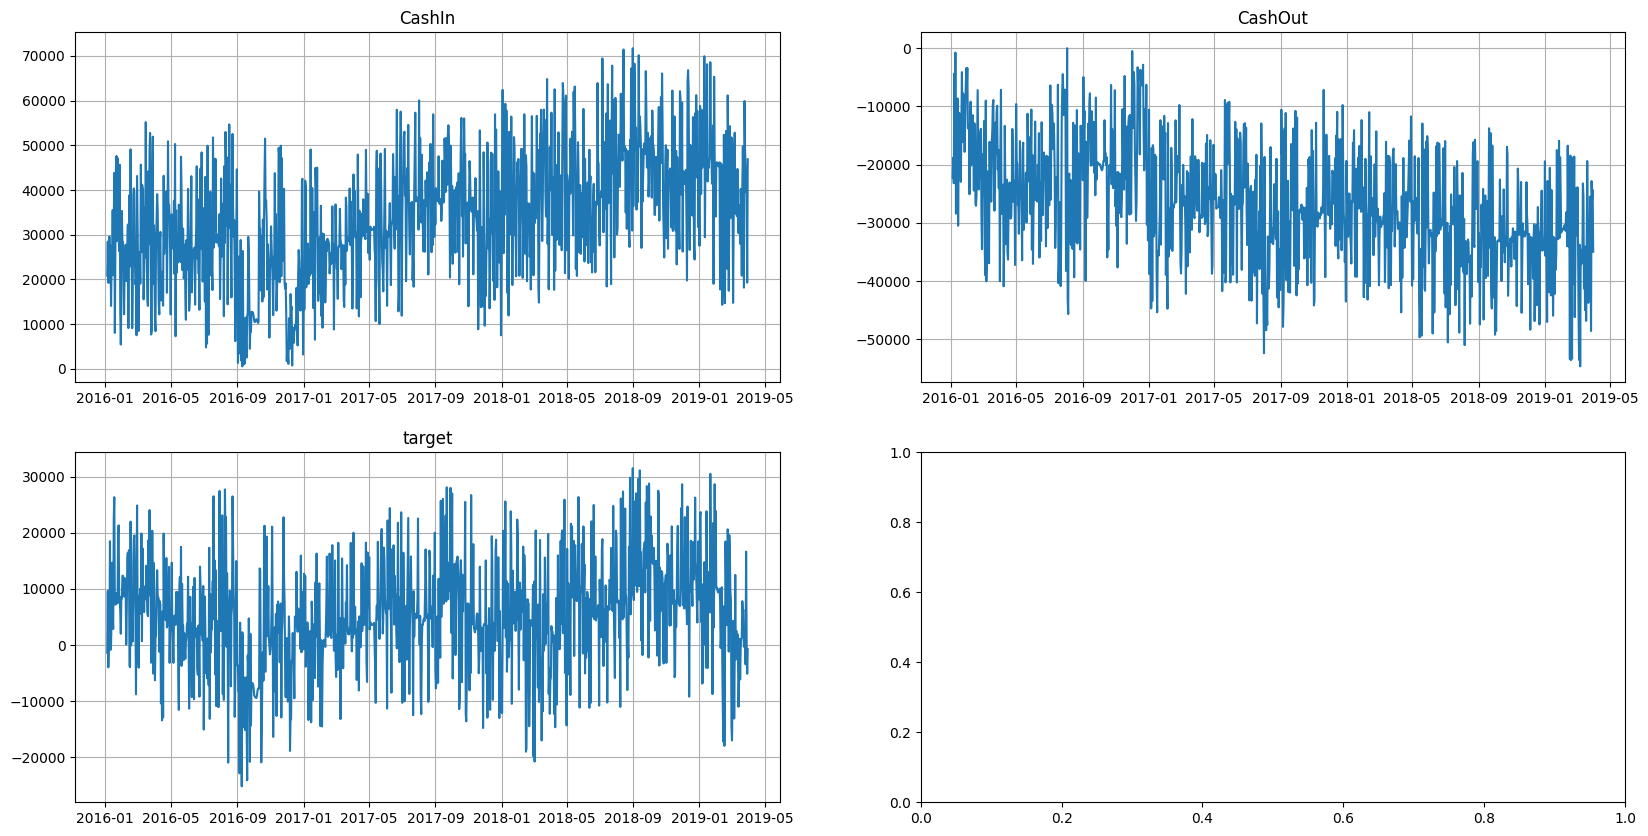

In [81]:
best_params = {"window_size": 32, "distance_coef": 1.2,"n_neighbors":14}
outliers_remover = DensityOutliersTransform(in_column="target", **best_params)
# Impute NaNs using the specified strategy
outliers_imputer = TimeSeriesImputerTransform(
    in_column="target", strategy="running_mean", window=31
)
ts_n.fit_transform([outliers_remover, outliers_imputer])
ts_n.plot()

In [82]:
transforms=[LagTransform(in_column="target", lags=[1,2,7,14,21,28], out_column="lag"),
                STLTransform(in_column="target", period=7, model="arima"),
                SegmentEncoderTransform(),
                MeanTransform(in_column="target", window=30,out_column="mean30"),
                HolidayTransform(iso_code="TUR", out_column="TUR_holidays"),
#                 DateFlagsTransform( special_days_in_week=[2],
#                                     out_column="date_flag" ),
                DateFlagsTransform( day_number_in_week=True,
                                    day_number_in_month=True,
                                    is_weekend=True,
                                    special_days_in_week=[2],
                                    out_column="date_flag" ),
#             TimeSeriesImputerTransform(in_column="target", window=30, strategy = "mean")
           ]

CatBoostMultiSeg_pipeline = Pipeline(
    model=CatBoostMultiSegmentModel(),
    transforms=transforms,
    horizon=HORIZON,
)
CatBoostPerSeg_pipeline = Pipeline(
    model=CatBoostModelPerSegment(),
    transforms=transforms,
    horizon=HORIZON,
)

pipeline_names = ["CB_MultiSegment", "CB_PerSegment"]
pipelines = [CatBoostMultiSeg_pipeline, CatBoostPerSeg_pipeline]

In [83]:
metrics = []
for pipeline in pipelines:
    metrics.append(
        [pipeline.backtest(
            ts=ts_n,
            metrics=[MAE(), SMAPE()],
            n_folds=5,
            aggregate_metrics=True,
        )]
    )

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   54.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  3.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  7.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 10.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elap

In [84]:
# metrics = pd.concat(metrics)
# metrics.index = pipeline_names
# forecast_catboost = deepcopy(ts)
# forecast_catboost["CashIn","target"]=metrics[0][0][1]["CashIn","target
metrics[0][0][0]

segment           MAE       SMAPE
0   CashIn  25315.664069   52.741930
1  CashOut   9749.113305   26.698993
2   target  16319.091301  148.820307

In [85]:
metrics[1][0][0]

segment           MAE       SMAPE
0   CashIn  20224.759922   47.037442
1  CashOut   9973.674983   28.410498
2   target  11682.804012  143.762181

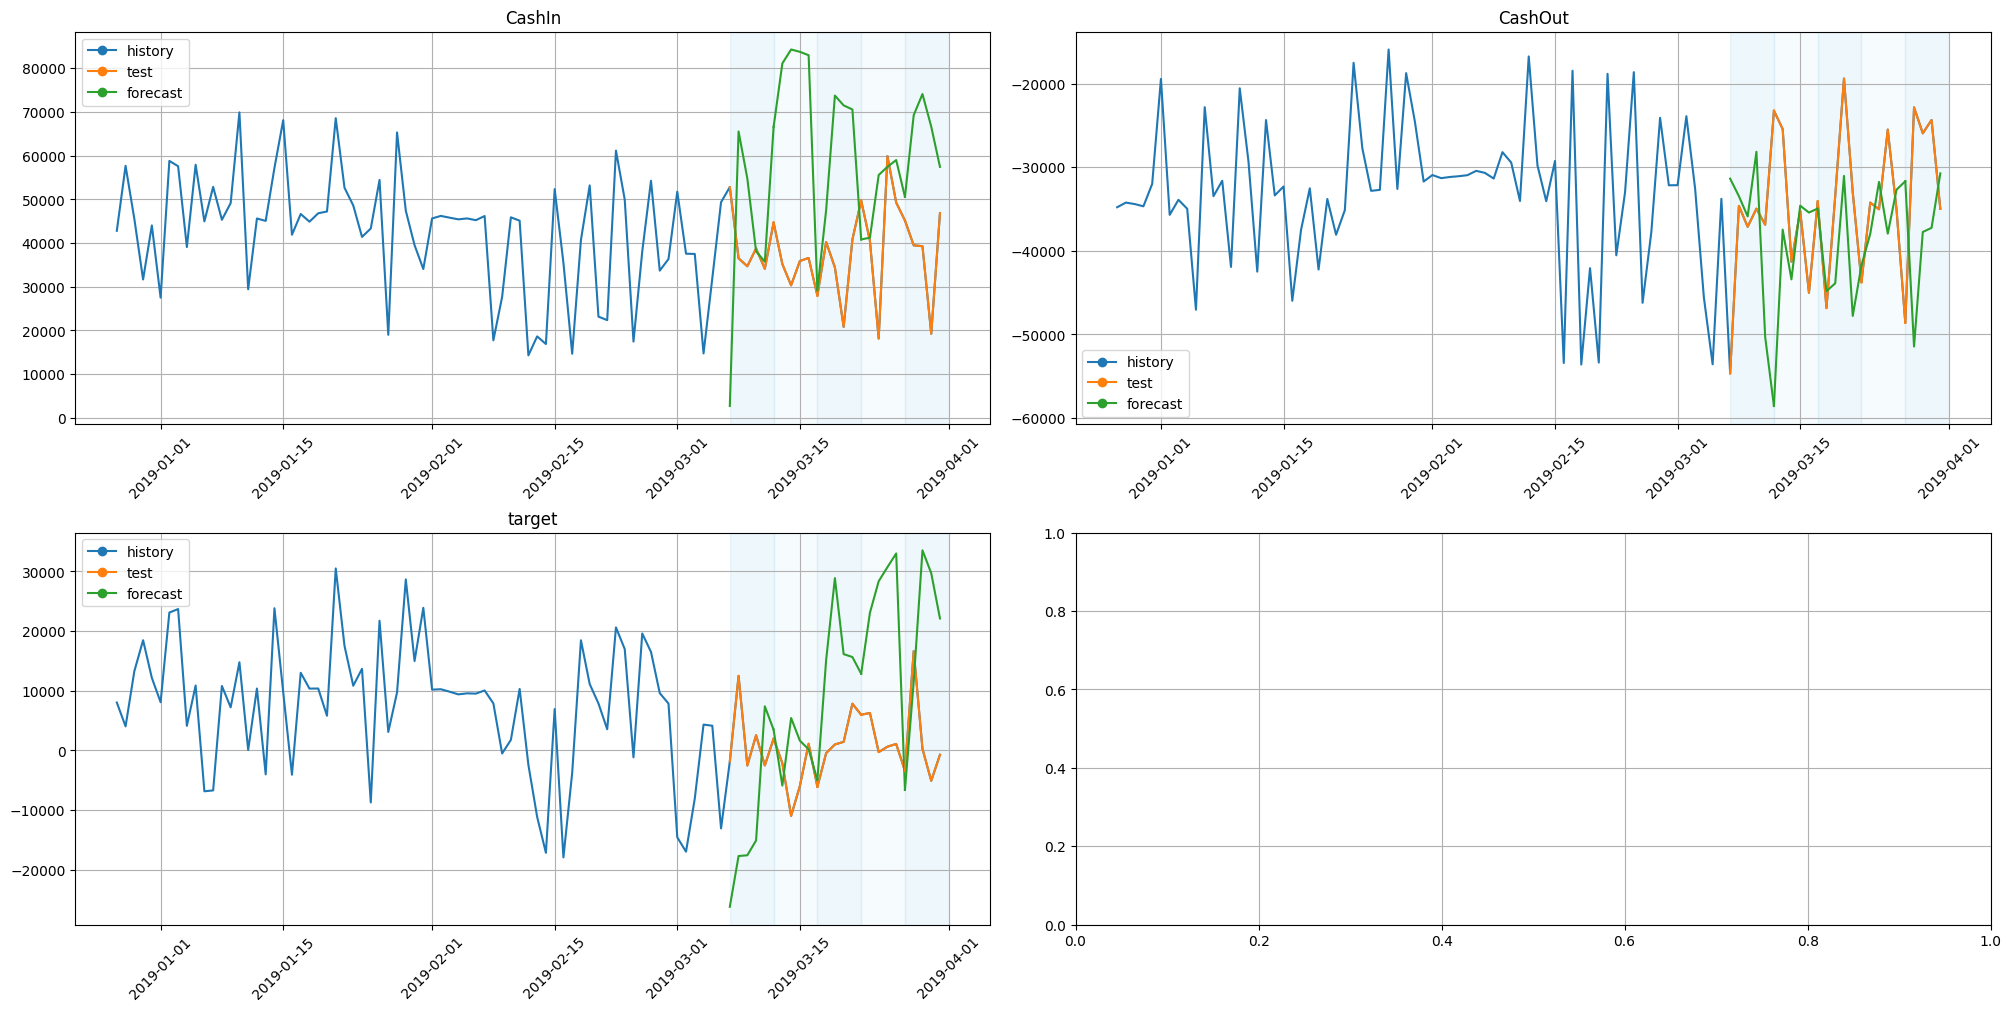

In [86]:
plot_backtest(metrics[0][0][1], ts_n, history_len=70)

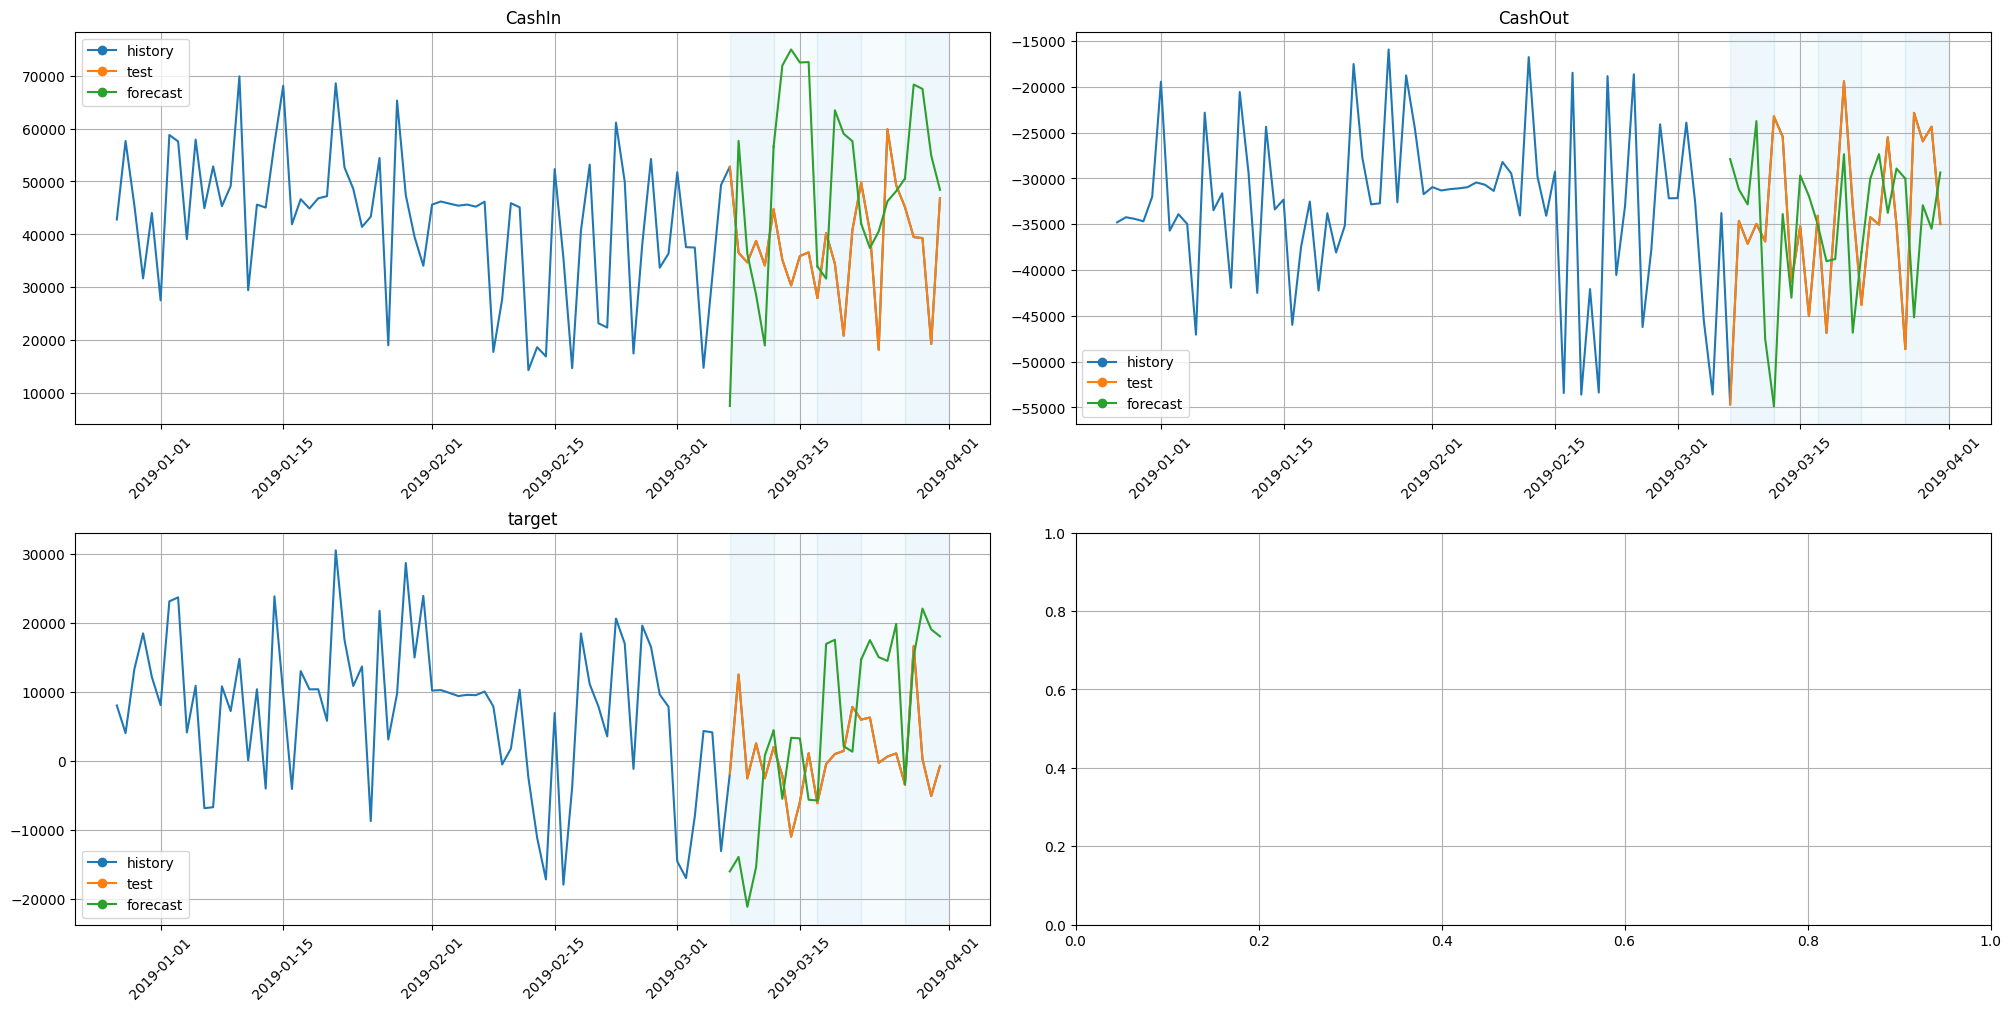

In [87]:
plot_backtest(metrics[1][0][1], ts_n, history_len=70)

In [88]:
transforms_ar=[
    LagTransform(in_column="target", lags=[23,24,28,30,31], out_column="lag"),
                STLTransform(in_column="target", period=7, model="arima"),
                SegmentEncoderTransform(),
                MeanTransform(in_column="target", window=30,out_column="mean30"),
                HolidayTransform(iso_code="TUR", out_column="TUR_holidays"),
#                 DateFlagsTransform( special_days_in_week=[2],
#                                     out_column="date_flag" ),
                DateFlagsTransform( day_number_in_week=True,
                                    day_number_in_month=True,
                                    is_weekend=True,
                                    special_days_in_week=[2],
                                    out_column="date_flag" ),
#             TimeSeriesImputerTransform(in_column="target", window=30, strategy = "mean")
           ]
AutoARIMA_pipeline = Pipeline(
    model=AutoARIMAModel(),
    transforms=transforms_ar,
    horizon=HORIZON,
)

In [89]:
metrics.append(
        [AutoARIMA_pipeline.backtest(
            ts=ts_n,
            metrics=[MAE(), SMAPE()],
            n_folds=4,
            aggregate_metrics=True,n_jobs=3
        )]
    )

[Parallel(n_jobs=3)]: Using backend MultiprocessingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:   36.8s
[Parallel(n_jobs=3)]: Done   2 out of   4 | elapsed:   45.3s remaining:   45.3s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed:  1.3min finished


In [90]:
metrics[-1][0][0]

segment           MAE       SMAPE
0   CashIn  14030.088541   36.947598
1  CashOut  10559.527081   31.342860
2   target   6047.952993  149.456033

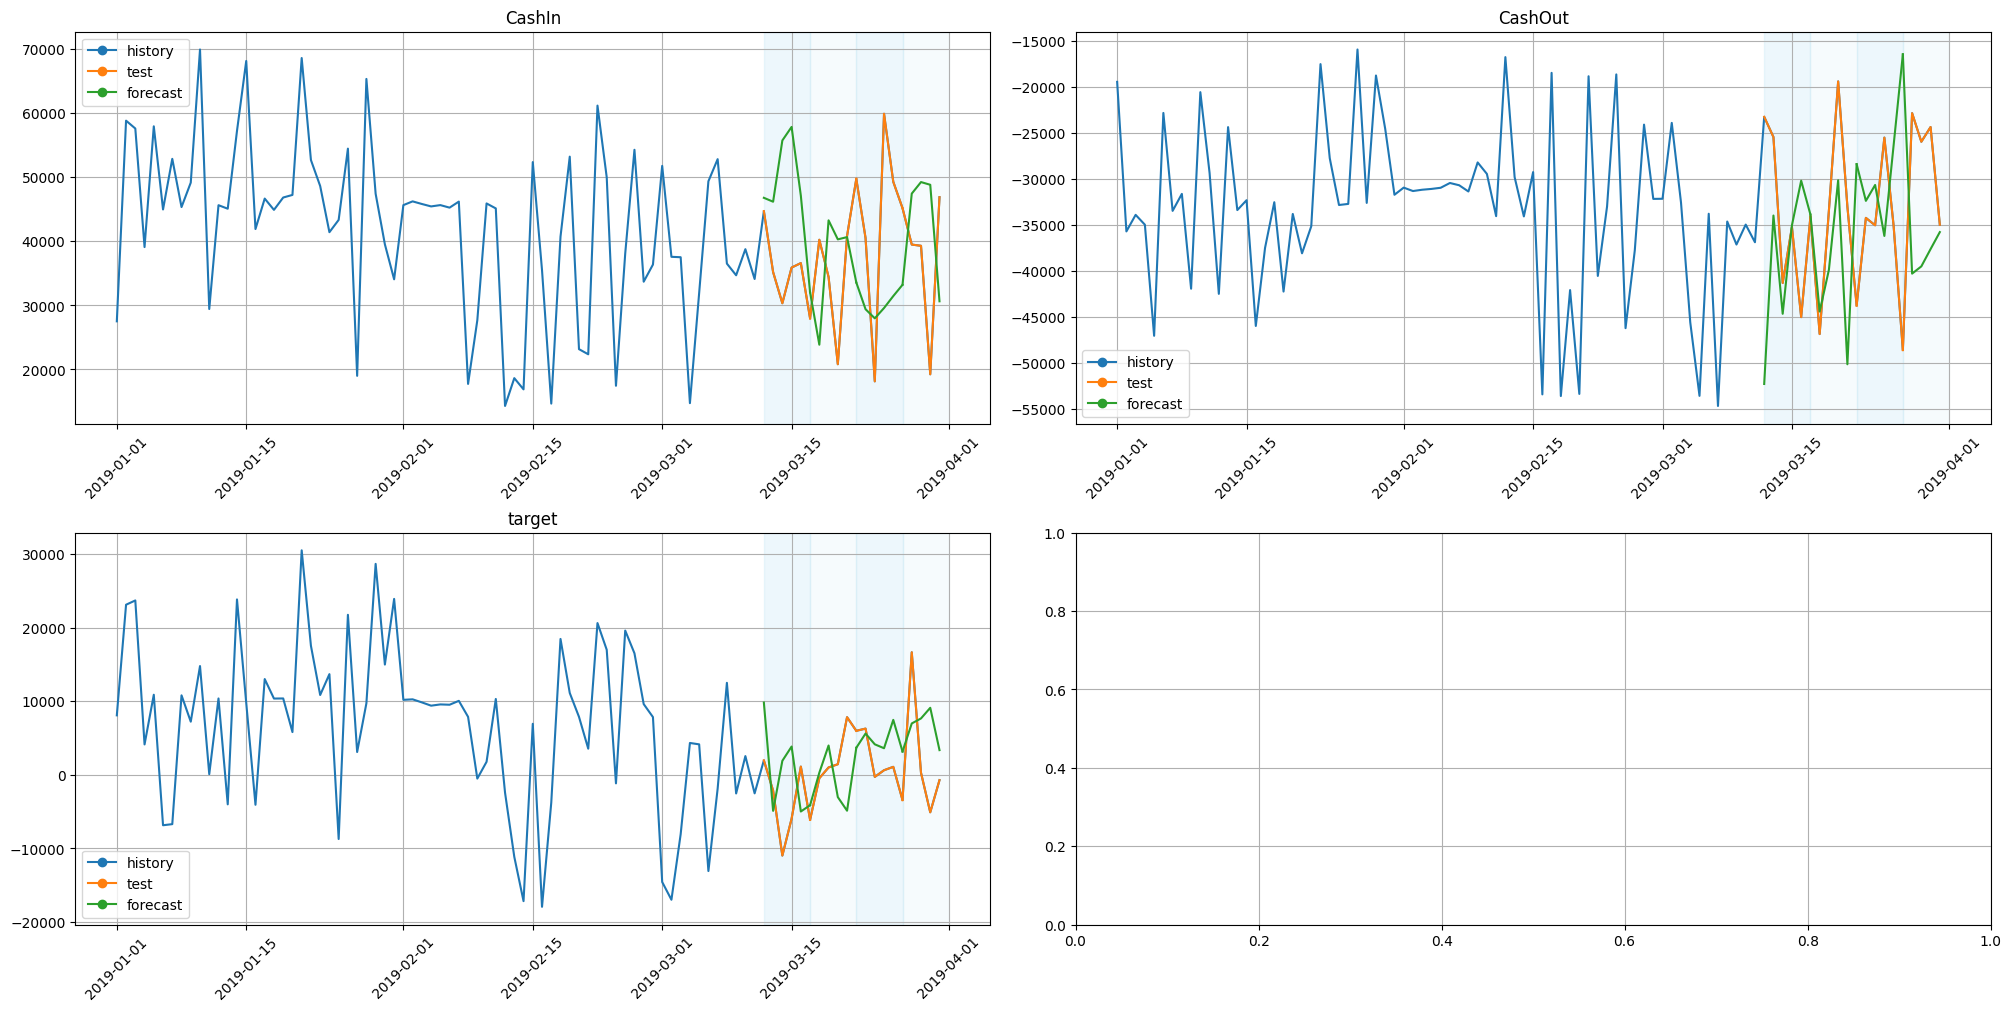

In [91]:
plot_backtest(metrics[-1][0][1], ts_n, history_len=70)

In [92]:
from etna.pipeline import AutoRegressivePipeline, Pipeline, assemble_pipelines
from etna.ensembles import DirectEnsemble

In [93]:
CatBoostMultiSeg_AG_pipeline = AutoRegressivePipeline(
    model=CatBoostMultiSegmentModel(),
    transforms=transforms,
    horizon=HORIZON, step=1
)
CatBoostPerSeg_AG_pipeline = AutoRegressivePipeline(
    model=CatBoostModelPerSegment(),
    transforms=transforms,
    horizon=HORIZON, step=1
)
pipeline_names_AG = ["CB_MultiSegment_AG", "CB_PerSegment_AG","ARIMA_AG"]
pipelines_AG = [CatBoostMultiSeg_AG_pipeline, CatBoostPerSeg_AG_pipeline]

In [94]:
metrics_ag = []
for pipeline in pipelines_AG:
    metrics_ag.append(
        [pipeline.backtest(
            ts=ts_n,
            metrics=[MAE(), SMAPE()],
            n_folds=4,
            aggregate_metrics=True
        )]
    )

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   53.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  3.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  3.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  7.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 10.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 10.0min finished


In [95]:
metrics_ag=[]

In [96]:
AutoARIMA_AG_pipeline = AutoRegressivePipeline(
    model=AutoARIMAModel(),
    transforms=transforms,
    horizon=HORIZON,step=1
)

In [97]:
metrics_ag.append(
        [AutoARIMA_pipeline.backtest(
            ts=ts_n,
            metrics=[MAE(), SMAPE()],
            n_folds=4,
            aggregate_metrics=True
        )]
    )

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   40.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.4min finished


In [98]:
for i,ar in enumerate(metrics_ag):
    print(pipeline_names_AG[i])
    print(ar[0][0].head(10))
    print("\n")

CB_MultiSegment_AG
   segment           MAE       SMAPE
0   CashIn  14015.669780   36.905326
1  CashOut  10559.527081   31.342860
2   target   6047.952993  149.456033




CB_MultiSegment_AG


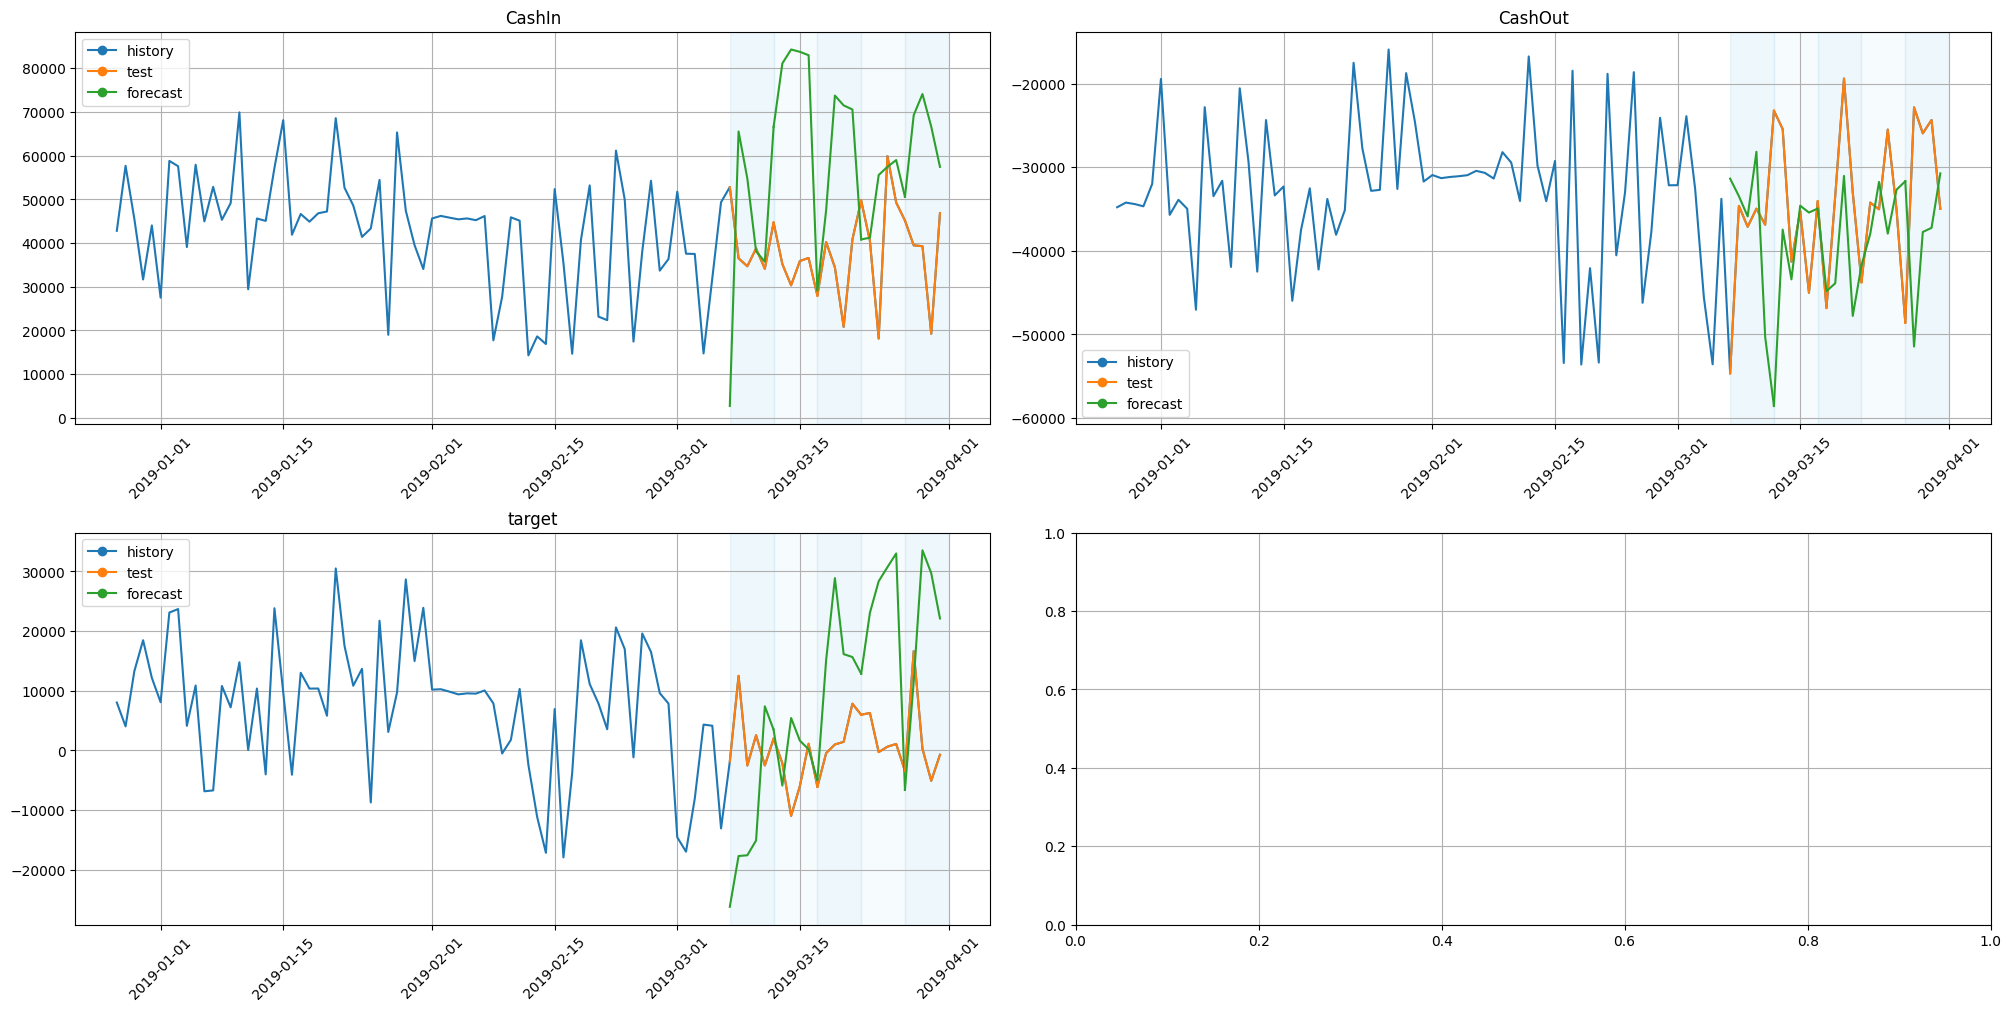

In [99]:
print(pipeline_names_AG[0])
plot_backtest(metrics[0][0][1],ts_n,history_len=70)

CB_PerSegment_AG


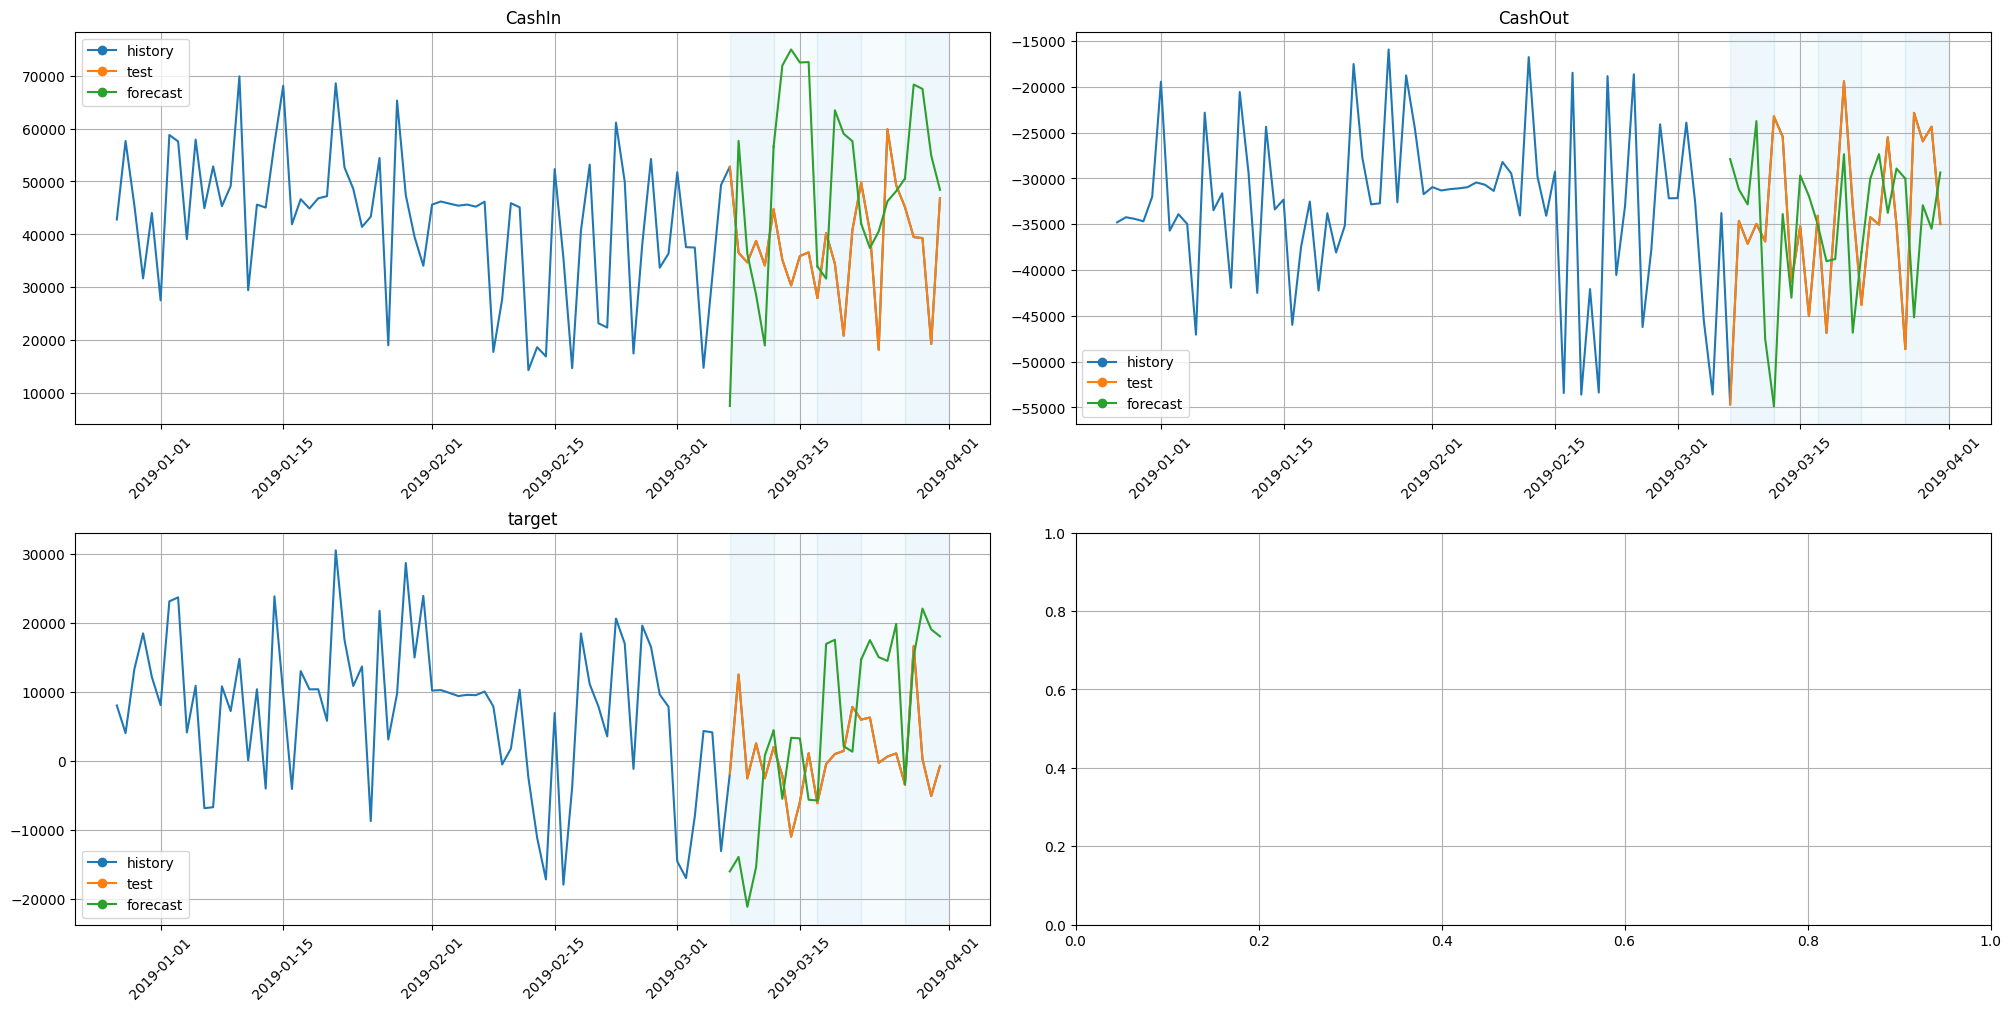

In [100]:
print(pipeline_names_AG[1])
plot_backtest(metrics[1][0][1],ts_n,history_len=70)

ARIMA_AG


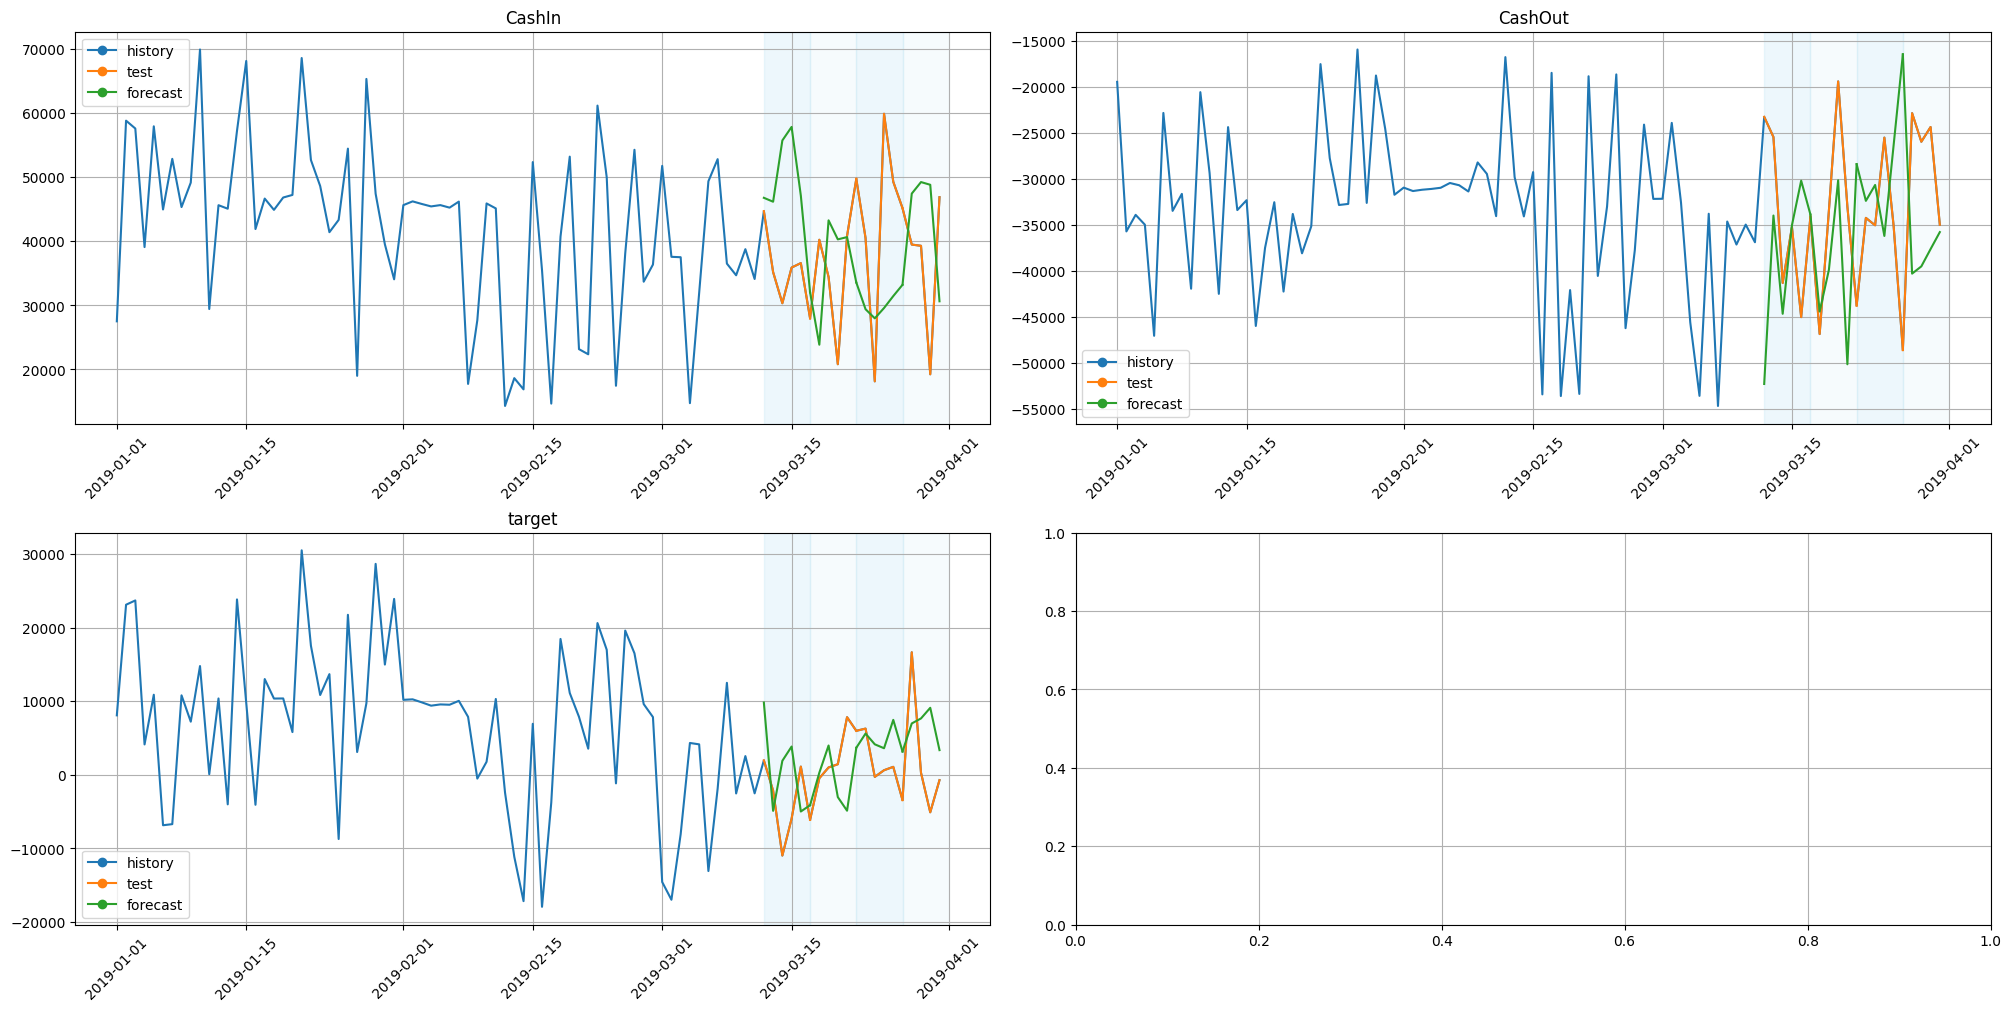

In [101]:
print(pipeline_names_AG[2])
plot_backtest(metrics[2][0][1],ts_n,history_len=70)

In [102]:
horizons = [1,5]
transforms_1=[
    LagTransform(in_column="target", lags=list(range(1,8)), out_column="lag"),
                STLTransform(in_column="target", period=7, model="arima"),
                SegmentEncoderTransform(),
                MeanTransform(in_column="target", window=14,out_column="mean30"),
                HolidayTransform(iso_code="TUR", out_column="TUR_holidays"),
#                 DateFlagsTransform( special_days_in_week=[2],
#                                     out_column="date_flag" ),
                DateFlagsTransform( day_number_in_week=True,
                                    day_number_in_month=True,
                                    is_weekend=True,
                                    special_days_in_week=[2],
                                    out_column="date_flag" ),
#             TimeSeriesImputerTransform(in_column="target", window=30, strategy = "mean")
           ]

transforms_2=[
    LagTransform(in_column="target", lags=[1,2,7,14,21,28,29,30,31], out_column="lag"),
                STLTransform(in_column="target", period=7, model="arima"),
                SegmentEncoderTransform(),
                MeanTransform(in_column="target", window=30,out_column="mean30"),
                HolidayTransform(iso_code="TUR", out_column="TUR_holidays"),
#                 DateFlagsTransform( special_days_in_week=[2],
#                                     out_column="date_flag" ),
                DateFlagsTransform( day_number_in_week=True,
                                    day_number_in_month=True,
                                    is_weekend=True,
                                    special_days_in_week=[2],
                                    out_column="date_flag" ),
#             TimeSeriesImputerTransform(in_column="target", window=30, strategy = "mean")
           ]


model_1 = CatBoostModelPerSegment()
pipeline_1 = Pipeline(model=model_1, transforms=transforms_1, horizon=horizons[0])


pipeline_2 = AutoRegressivePipeline(
    model=CatBoostModelPerSegment(),
    transforms=transforms_2,
    horizon=horizons[1],step=1
)


In [103]:
ensemble = DirectEnsemble(pipelines=[pipeline_1, pipeline_2])

metrics_ensemble_df, forecast_ensemble_df, k = ensemble.backtest(
    ts=ts_n, metrics=[SMAPE(), MAE()]
)

ensemble_metrics = metrics_ensemble_df.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.

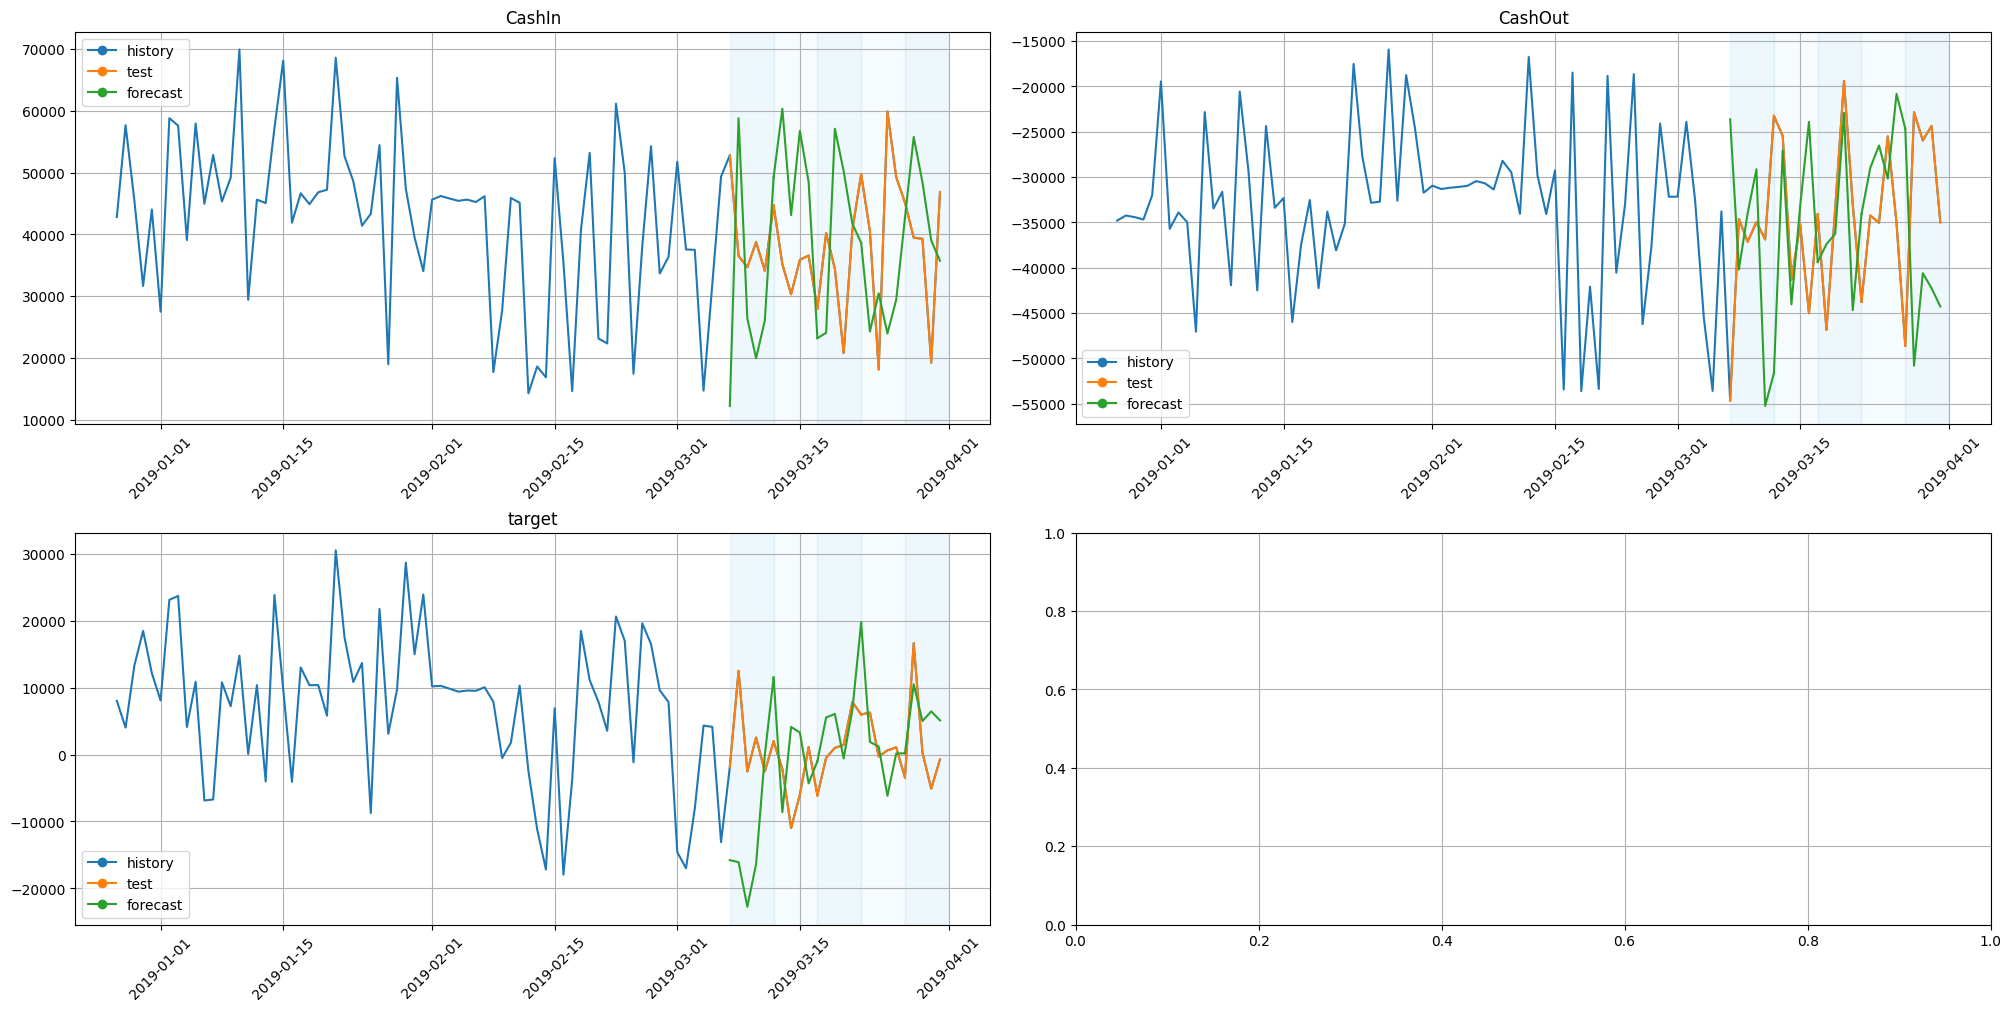

In [104]:
plot_backtest(forecast_ensemble_df, ts_n, history_len=70)

In [105]:
metrics_ensemble_df

segment       SMAPE           MAE  fold_number
0   CashIn   57.792260  19573.509205            0
0   CashIn   34.000866  15032.027150            1
0   CashIn   40.636486  14769.504132            2
0   CashIn   52.357566  19068.085024            3
0   CashIn   31.097245  11760.676999            4
2  CashOut   32.220720  12791.355572            0
2  CashOut   31.137753  11181.821246            1
2  CashOut   18.330360   6552.197521            2
2  CashOut   27.410411   8480.030610            3
2  CashOut   52.494711  18744.163087            4
1   target  182.051583  16801.633667            0
1   target  172.358759   9153.663781            1
1   target  140.505189   3858.465556            2
1   target  153.137961   5463.079813            3
1   target  165.011027   6374.132199            4

### Задание 8. Ансамбли (1.25 балла)

Чтобы не выбирать лучшую модель, мы можем использовать преимущества каждой - давайте объединим все наши наработки в ансамбль. Попробуйте различные опции ансамблирования, и выберите ту, которая работает лучше всего (не забывайте, что внутри каждого ансамбля у нас тоже есть параметры, которые мы можем варьировать - веса в voting, включаемые признаки в stacking).

In [106]:
HORIZON = 5

In [107]:
from etna.ensembles import StackingEnsemble, VotingEnsemble

In [108]:
transforms=[
    LagTransform(in_column="target", lags=[1,2,7,14,21,28], out_column="lag"),
                STLTransform(in_column="target", period=7, model="arima"),
                SegmentEncoderTransform(),
                MeanTransform(in_column="target", window=30,out_column="mean30"),
                HolidayTransform(iso_code="TUR", out_column="TUR_holidays"),
#                 DateFlagsTransform( special_days_in_week=[2],
#                                     out_column="date_flag" ),
                DateFlagsTransform( day_number_in_week=True,
                                    day_number_in_month=True,
                                    is_weekend=True,
                                    special_days_in_week=[2],
                                    out_column="date_flag" ),
#             TimeSeriesImputerTransform(in_column="target", window=30, strategy = "mean")
           ]

In [109]:
CatBoostMultiSeg_AG_pipeline = Pipeline(
    model=CatBoostMultiSegmentModel(),
    transforms=transforms,
    horizon=HORIZON
)
CatBoostPerSeg_AG_pipeline = Pipeline(
    model=CatBoostModelPerSegment(),
    transforms=transforms,
    horizon=HORIZON
)
AutoARIMA_AG_pipeline = AutoRegressivePipeline(
    model=AutoARIMAModel(),
    transforms=transforms,
    horizon=HORIZON,step=1
)
pipeline_names_AG = ["CB_MultiSegment_AG", "CB_PerSegment_AG","ARIMA_AG"]
pipelines_n = [CatBoostMultiSeg_AG_pipeline, 
               CatBoostPerSeg_AG_pipeline,
               AutoARIMA_AG_pipeline]

In [27]:
stacking_ensemble_unfeatured = StackingEnsemble(
    pipelines=pipelines_n, n_folds=5, n_jobs=3
)

In [ ]:
metric_stack=stacking_ensemble_unfeatured.backtest(
    ts=ts_n,
    metrics=[MAE(), SMAPE()],
    n_folds=4,
    aggregate_metrics=True, n_jobs=3
)

[Parallel(n_jobs=3)]: Using backend MultiprocessingBackend with 3 concurrent workers.


In [ ]:
metric_stack[1]

In [ ]:
stacking_ensemble_unfeatured = StackingEnsemble(pipelines=pipelines, n_folds=10, n_jobs=3)

### Задание 9*. Трансформер (бонус 2 балла)

Для желающих протестировать мощь трансформенных моделей предлагается "завести" модель из второго семинара по временным рядам на текущем датасете. На этот раз абсолютно все необходимые импорты и зависимости подгружаются на ваше усмотрение. Удалось ли вам улучшить качество по сравнению с классическими моделями / моделями на основе ML? Что бы вы предпочли внедрить в production?

*NB:* все, конечно, прекрасно знают механизм работы бонусных заданий, но порядка ряди прописать дисклеймер должны - итоговый балл за домашнее задание ставится по формуле min(10, ваш суммарный балл за задания).

In [ ]:
#YOUR CODE HERE#